## Imports

In [3]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from pandas.plotting import scatter_matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score, classification_report, fbeta_score, accuracy_score
from sklearn.feature_selection import RFECV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
import statsmodels.api as sm
from boruta import BorutaPy

import custom_map

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import importlib

importlib.reload(custom_map)

<module 'custom_map' from '/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py'>

## Data and feature engineering

In [5]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
target = "stroke"

categorical_features = data.select_dtypes(['object']).columns.tolist()
numerical_features = data.select_dtypes(['float64', 'int64']).columns.drop('id')
categorical_features.append('stroke')

print(categorical_features, '\n', numerical_features)

data.head()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'] 
 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


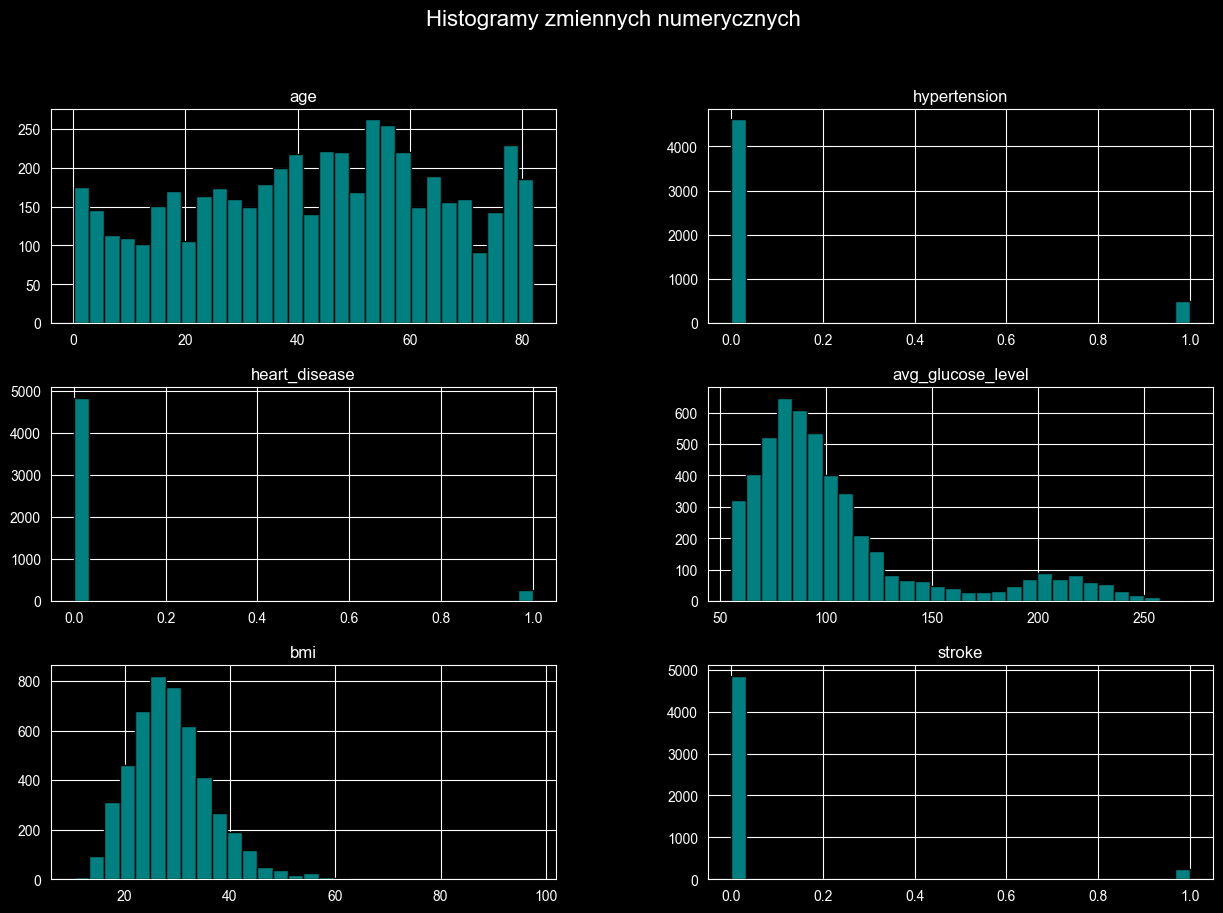

In [7]:
data[numerical_features].hist(bins=30, figsize=(15, 10), color="teal", edgecolor='black')
plt.suptitle("Histogramy zmiennych numerycznych", fontsize=16)
plt.show()

In [8]:
bmi_median = data['bmi'].median()
bmi_mean = data['bmi'].mean()
print(bmi_median, bmi_mean)

data['bmi'] = data['bmi'].fillna(bmi_median)

28.1 28.893236911794666


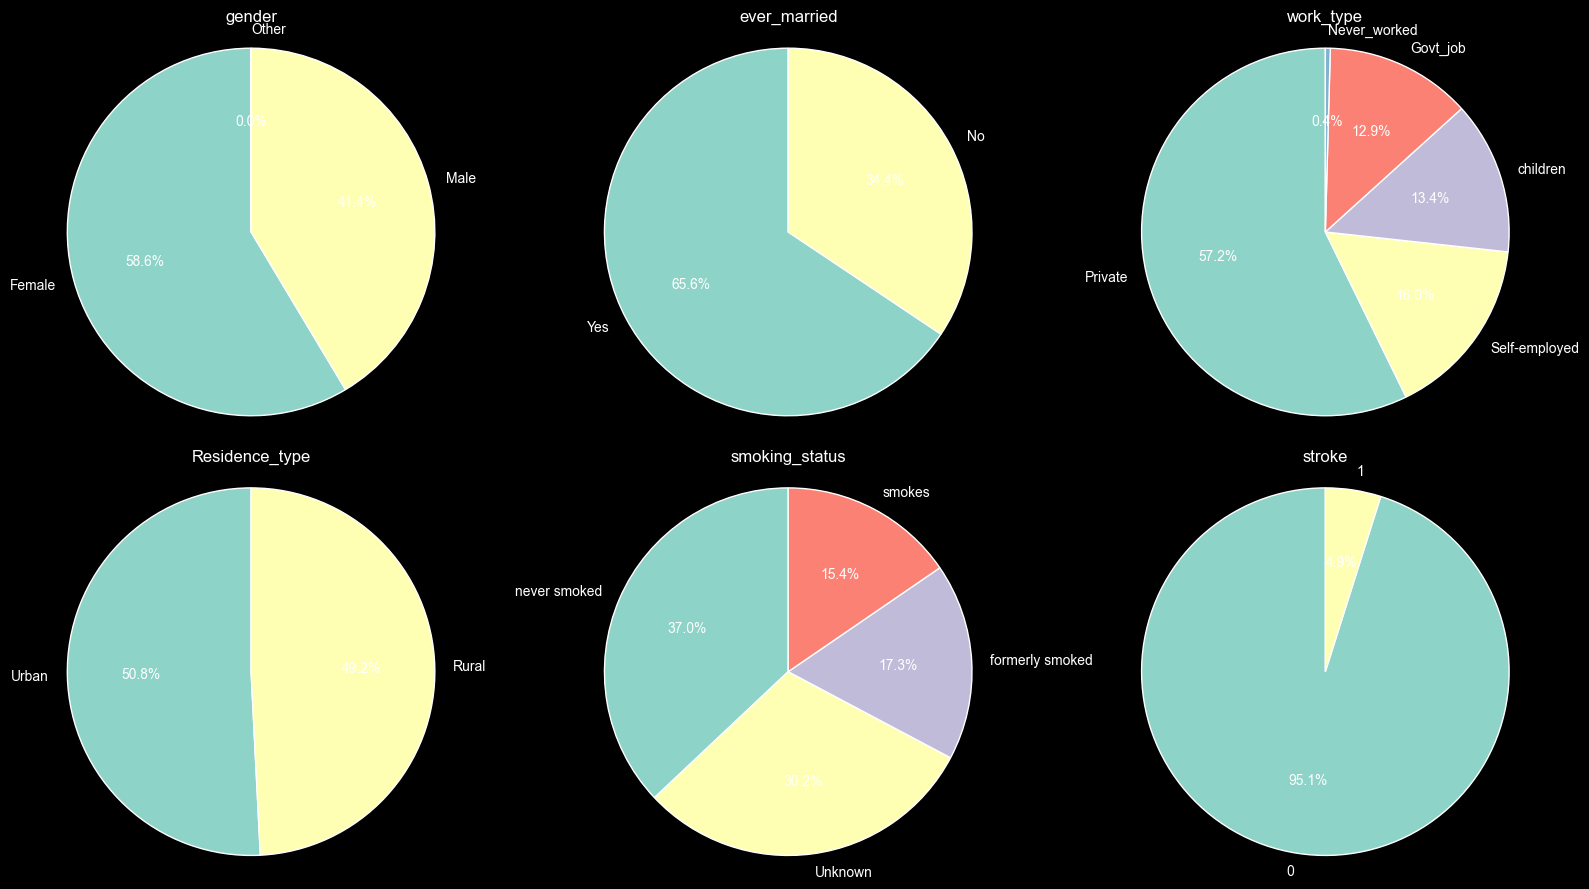

In [9]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
axes = axes.flat

for ax, col in zip(axes, categorical_features):
    sizes = data[col].value_counts()
    labels = sizes.index.astype(str)

    ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.set_title(col)
    ax.axis("equal")

plt.tight_layout()
plt.show()

In [10]:
categorical_features.remove('stroke')
data = pd.get_dummies(data, columns=categorical_features, drop_first=True, dtype=float)
data = data.drop('id', axis=1)

{'name': 'bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:29: UserWarning: Overwriting the cmap 'bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


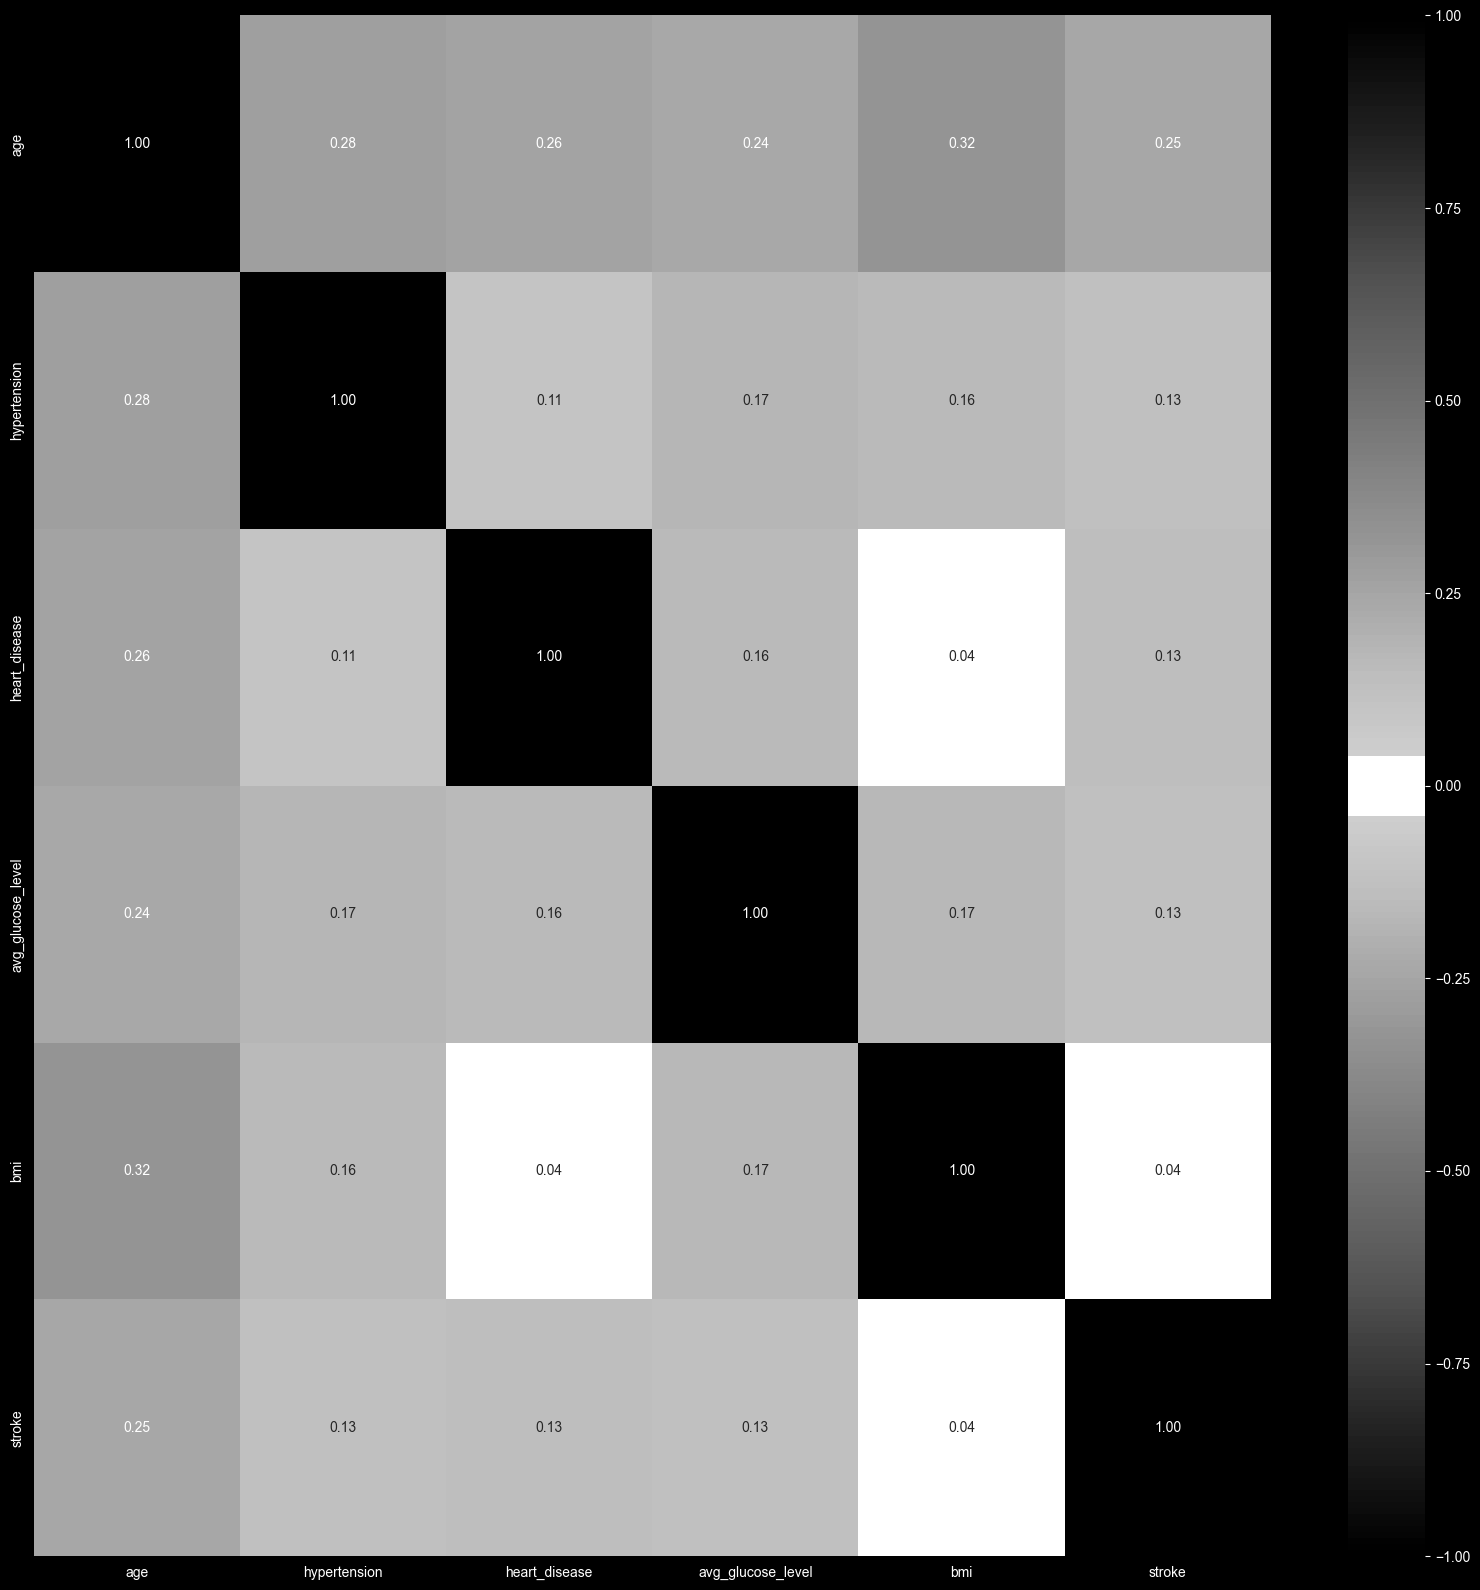

In [11]:
correlation_data = data[numerical_features].corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="bajon", vmin=-1, vmax=1) #tab20b
plt.tight_layout()
plt.show()

{'name': 'bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:29: UserWarning: Overwriting the cmap 'bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


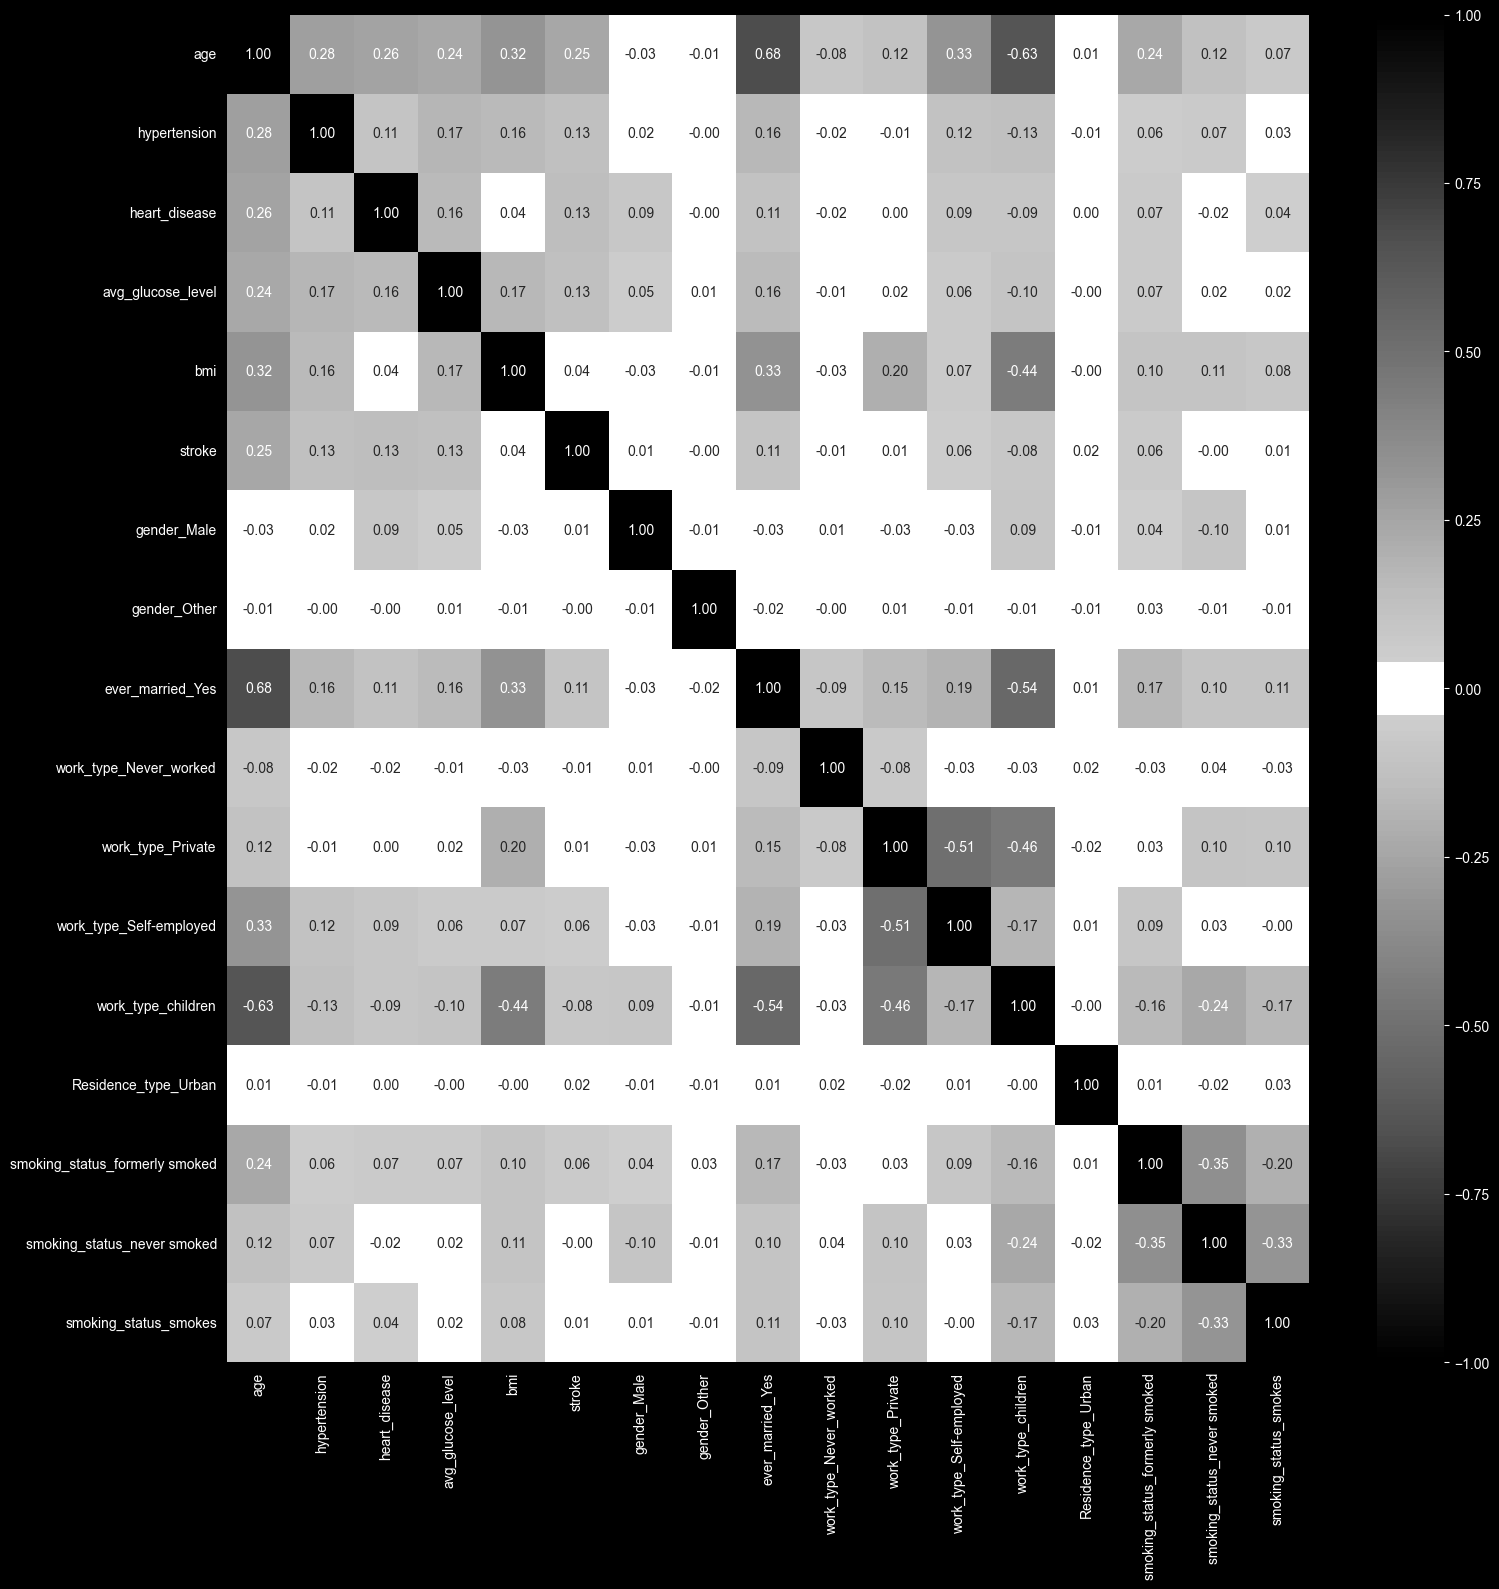

In [12]:
correlation_data = data.corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="bajon", vmin=-1, vmax=1) #tab20b #bajon
plt.tight_layout()
plt.show()

In [13]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature selection

In [14]:
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    class_weight="balanced",
)

boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',   # lub liczba
    max_iter=100,
    alpha=0.05
)

boruta.fit(X_train, y_train)

selected_mask = boruta.support_
selected_features = np.where(selected_mask)[0]
print("Wybrane cechy (indeksy):", selected_features)
print("Ranking:", boruta.ranking_)

Wybrane cechy (indeksy): [0 3 4]
Ranking: [ 1  3  5  1  1 10 14  2 13 11  6  4  7  7  9 12]


In [13]:
selected_indices = np.where(boruta.support_)[0]
boruta_features = X_train.columns[selected_indices].tolist()

boruta_features

['age', 'avg_glucose_level', 'bmi']

In [14]:
corr_features = data.corr()[target].sort_values(ascending=False)
corr_features = corr_features[corr_features > custom_map.cmap_pearson(n_features, n, 0.1)['r_crit']].index.tolist()

corr_features.remove('stroke')
corr_features

/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:29: UserWarning: Overwriting the cmap 'bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


['age',
 'heart_disease',
 'avg_glucose_level',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_formerly smoked',
 'work_type_Self-employed']

In [15]:
data[corr_features].head()

,age,heart_disease,avg_glucose_level,hypertension,ever_married_Yes,smoking_status_formerly smoked,work_type_Self-employed
0,67.0,1,228.69,0,1.0,1.0,0.0
1,61.0,0,202.21,0,1.0,0.0,1.0
2,80.0,1,105.92,0,1.0,0.0,0.0
3,49.0,0,171.23,0,1.0,0.0,0.0
4,79.0,0,174.12,1,1.0,0.0,1.0


In [16]:
X_chosen = data[corr_features].copy()
X_scaled = scaler.fit_transform(X_chosen)

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=20
)

clusters = kmeans.fit_predict(X_scaled)
X_chosen["cluster"] = clusters

X_chosen["cluster"].describe()

count    5110.000000
mean        0.429159
std         0.594200
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: cluster, dtype: float64

In [17]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4088 entries, 2377 to 4960
Series name: stroke
Non-Null Count  Dtype
--------------  -----
4088 non-null   int64
dtypes: int64(1)
memory usage: 63.9 KB


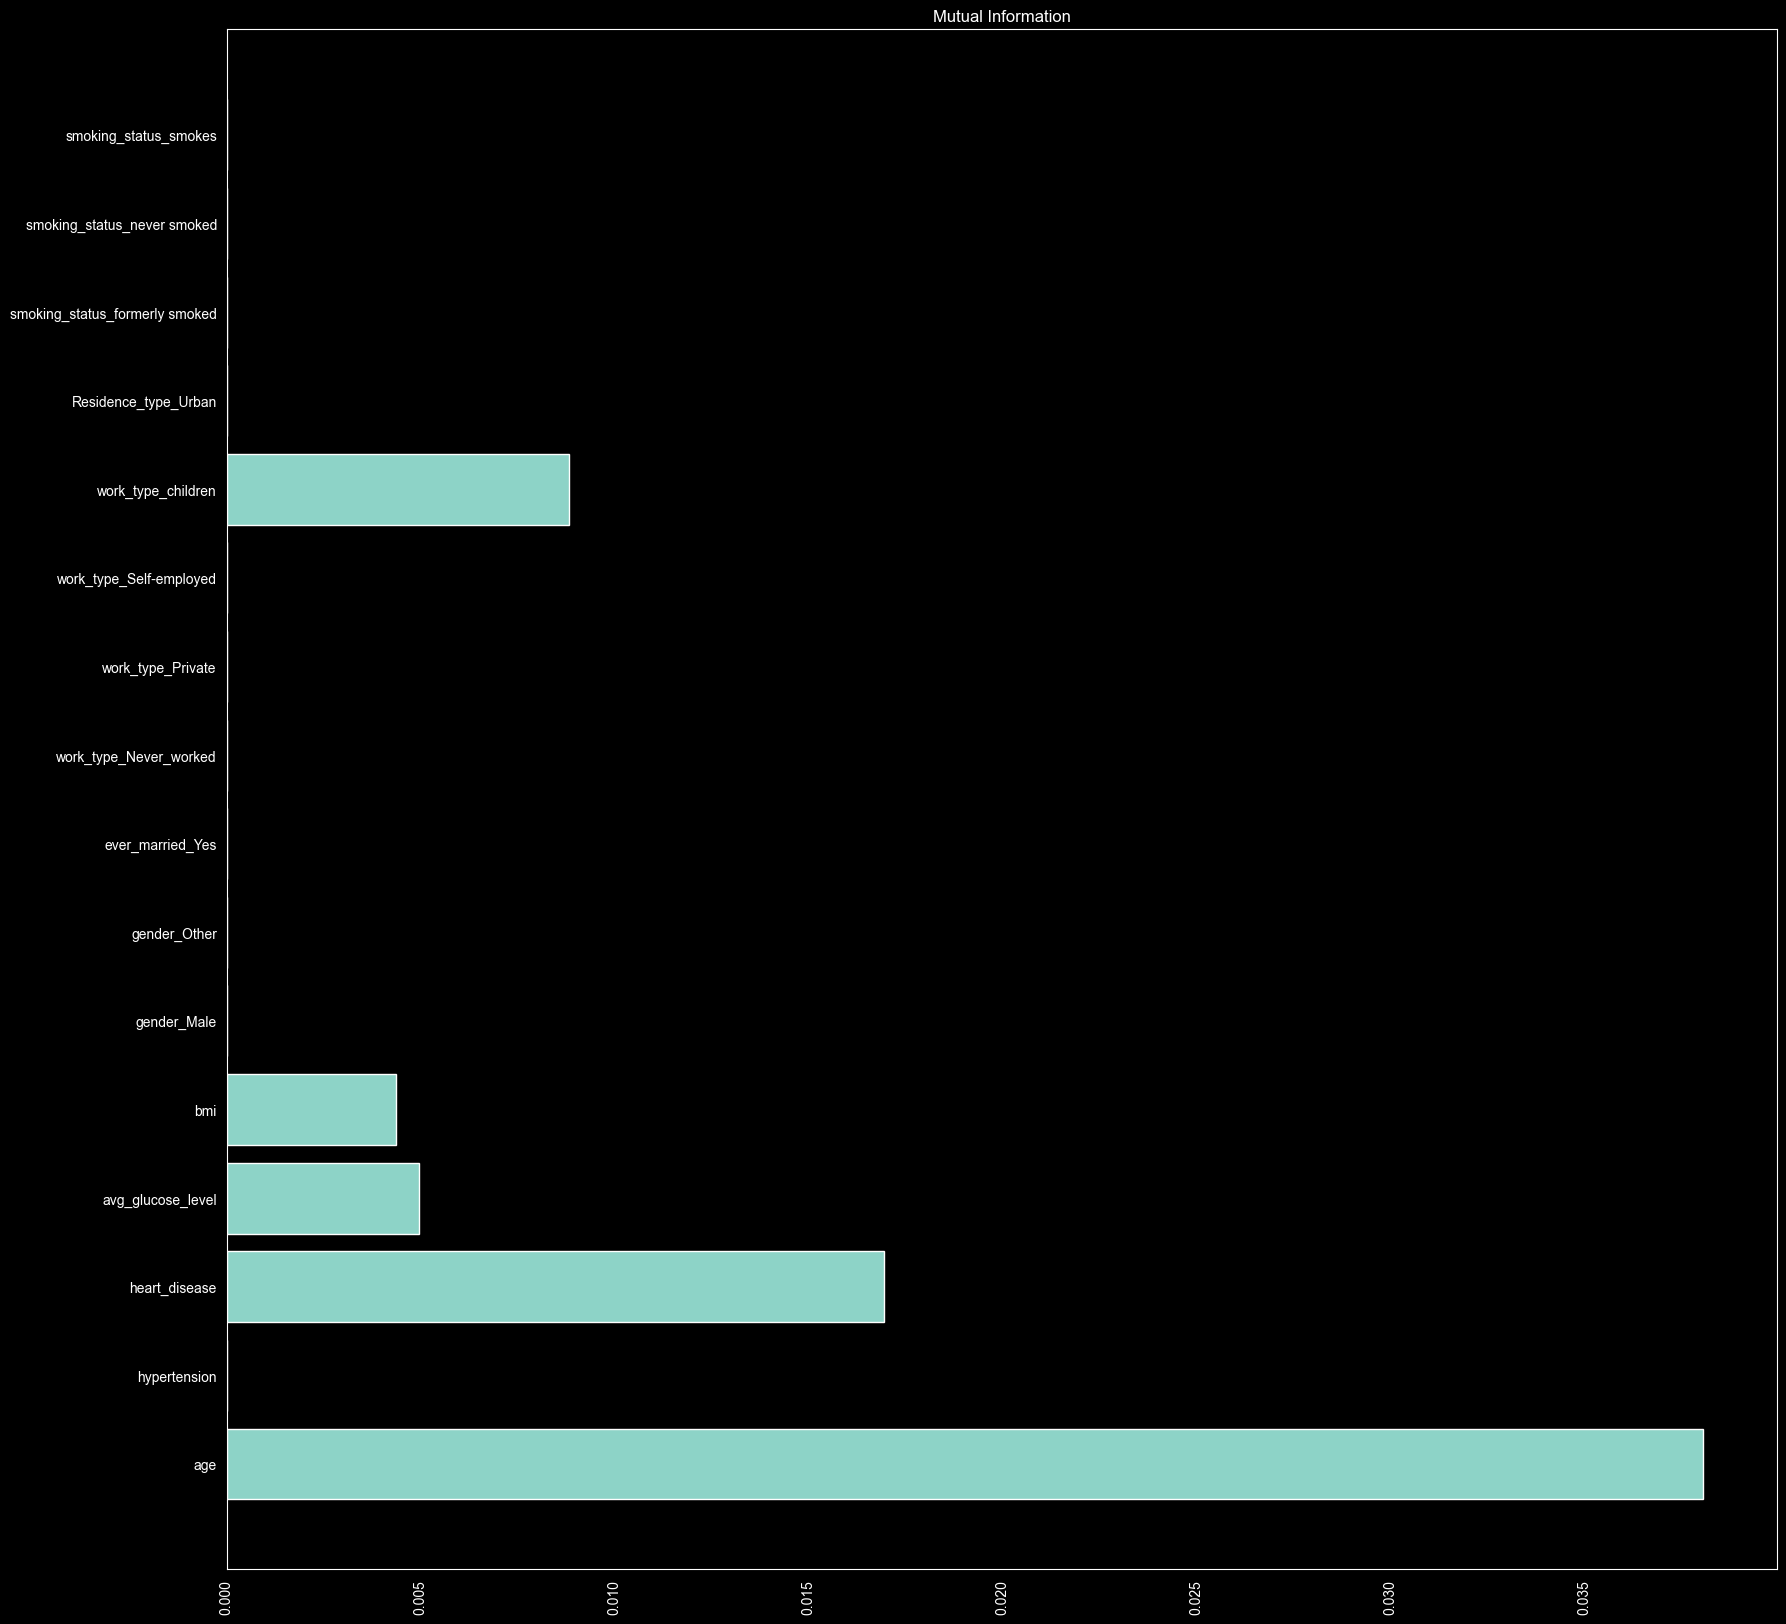

,Feature,Mutual Information
0,age,0.038057
1,hypertension,0.000000
2,heart_disease,0.016960
3,avg_glucose_level,0.004958
4,bmi,0.004379
5,gender_Male,0.000000
6,gender_Other,0.000000
7,ever_married_Yes,0.000000
8,work_type_Never_worked,0.000000
9,work_type_Private,0.000000


In [18]:
sample_idx = np.random.choice(len(X_train), size=int(X_train.size/20), replace=False)

mi = mutual_info_regression(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
mi_df = pd.DataFrame({"Feature": X_train.columns, "Mutual Information": mi})

plt.figure(figsize=(20, 20))
plt.barh(X_train.columns, mi)
plt.grid(False)
plt.xticks(rotation=90)
plt.title('Mutual Information')
plt.show()
mi_df



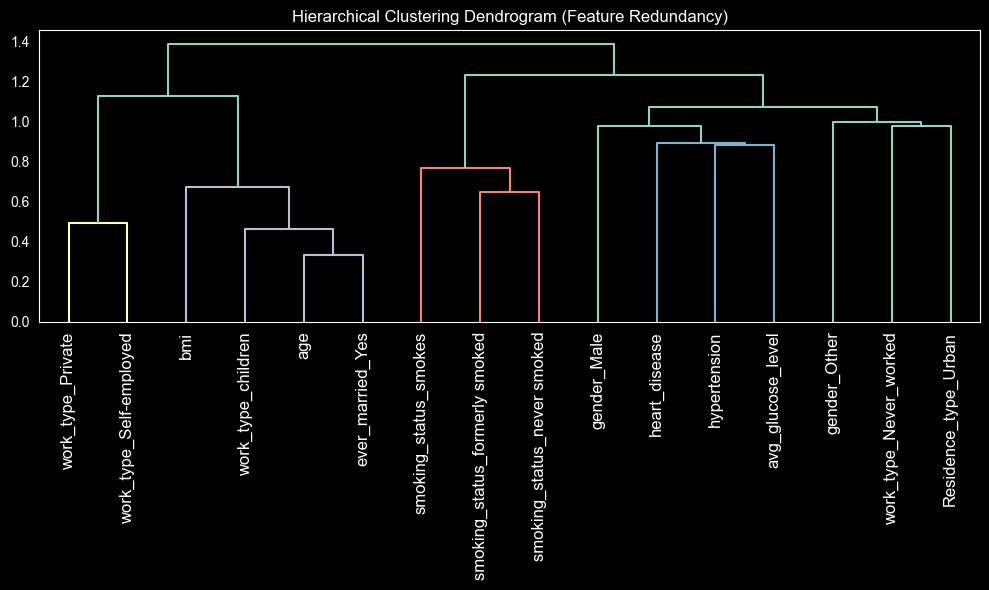

Original features: 16
Reduced features: 5
Selected: Index(['age', 'hypertension', 'gender_Other', 'work_type_Private',
       'smoking_status_formerly smoked'],
      dtype='object')


In [19]:
names = X_train.columns
# 1. Compute Spearman correlation and distance matrix
# Assuming X is your dataframe of explanatory variables
corr = spearmanr(X).correlation
# Ensure the matrix is symmetric (sometimes float errors occur)
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation to a distance matrix
dist_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(hierarchy.distance.squareform(dist_matrix))

# 2. Visualize the Dendrogram
fig, ax = plt.subplots(figsize=(10, 6))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=names, ax=ax, leaf_rotation=90
)
ax.set_title("Hierarchical Clustering Dendrogram (Feature Redundancy)")
plt.tight_layout()
plt.grid(False)
plt.show()

# 3. Select Features
# Threshold '1' is common for 1 - abs(corr), but you can adjust based on the plot
cluster_ids = hierarchy.fcluster(dist_linkage, t=1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Keep only the first feature from each cluster
selected_idx = [v[0] for v in cluster_id_to_feature_ids.values()]
mi_features = names[selected_idx]
X_reduced = X_train.iloc[:, selected_idx]


print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(mi_features)}")
print(f"Selected: {mi_features}")

In [20]:
def calculate_vif(df: pd.DataFrame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns

    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    print(vif_data)

In [21]:
calculate_vif(X_train.drop(columns=["age", "bmi"]))

                           feature       VIF
0                     hypertension  1.171953
1                    heart_disease  1.111942
2                avg_glucose_level  5.532207
3                      gender_Male  1.714095
4                     gender_Other  1.003319
5                 ever_married_Yes  3.832063
6           work_type_Never_worked  1.029751
7                work_type_Private  3.630876
8          work_type_Self-employed  1.815644
9               work_type_children  1.617963
10            Residence_type_Urban  1.905230
11  smoking_status_formerly smoked  1.790903
12     smoking_status_never smoked  2.422314
13           smoking_status_smokes  1.645118


In [22]:
vif_features = X_train.drop(columns=["age", "bmi"]).columns.tolist()
vif_features

['hypertension',
 'heart_disease',
 'avg_glucose_level',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [23]:
model = LogisticRegression(
    solver="lbfgs",
    max_iter=10000,
    class_weight="balanced",
    random_state=42
)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=3
)

rfecv.fit(X_train_scaled, y_train)

rfe_features = X_train.columns[rfecv.support_].tolist()
ranking = pd.DataFrame({
    "feature": X_train.columns,
    "rank": rfecv.ranking_
}).sort_values("rank")

print("Liczba wybranych cech:", len(rfe_features))
print("Wybrane cechy:")
print(rfe_features)

Liczba wybranych cech: 3
Wybrane cechy:
['age', 'avg_glucose_level', 'work_type_Never_worked']


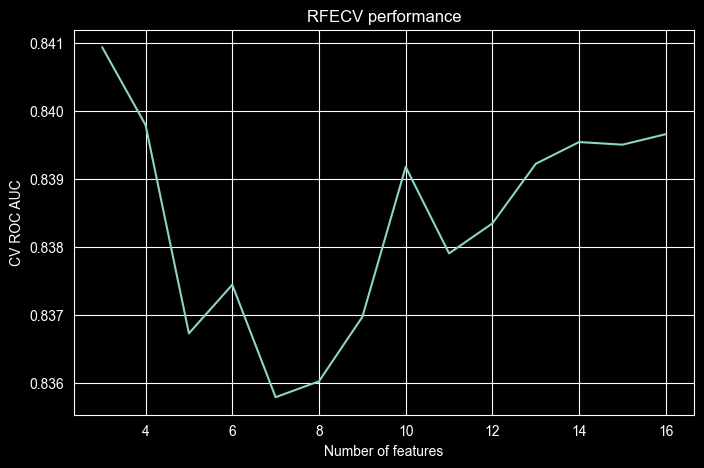

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(
    range(rfecv.min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + rfecv.min_features_to_select),
    rfecv.cv_results_["mean_test_score"]
)
plt.xlabel("Number of features")
plt.ylabel("CV ROC AUC")
plt.title("RFECV performance")
plt.grid(True)
plt.show()


## Model training

In [15]:
## hard coding because of stochasticity

all_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "gender_Male", "gender_Other", "ever_married_Yes",
                "work_type_Never_worked", "work_type_Private", "work_type_Self-employed",
                "work_type_children", "Residence_type_Urban",
                "smoking_status_formerly smoked", "smoking_status_never smoked",
                "smoking_status_smokes"]

boruta_features = ["age", "avg_glucose_level", "bmi"]

corr_features = ["age", "heart_disease", "avg_glucose_level", "hypertension",
                 "ever_married_Yes", "smoking_status_formerly smoked",
                 "work_type_Self-employed"]

mi_features = ["age", "hypertension", "gender_Other",
               "work_type_Private", "smoking_status_formerly smoked"]

rfe_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "work_type_Never_worked", "work_type_children",
                "Residence_type_Urban", "smoking_status_never smoked",
                "smoking_status_smokes"]

FEATURE_SETS = {
    "all": all_features,
    "boruta": boruta_features,
    "correlation": corr_features,
    "mi": mi_features,
    "rfe": rfe_features
}

In [16]:
X_train_all = X_train[all_features] # all features
X_train_boruta = X_train[boruta_features].copy() # boruta selection
X_train_corr = X_train[corr_features].copy() # cmap correlation
X_train_mi = X_train[mi_features].copy() # correlation, mi & clustering
X_train_rfe = X_train[rfe_features].copy() # rfecv

data = {
    "Method": [
        "All features",
        "Boruta",
        "Corelation",
        "Mutual Information",
        "RFE"
    ],
    "Feature quantity": [
        len(all_features),
        len(boruta_features),
        len(corr_features),
        len(mi_features),
        len(rfe_features)
    ],
    "Feature name": [
        ", ".join(all_features),
        ", ".join(boruta_features),
        ", ".join(corr_features),
        ", ".join(mi_features),
        ", ".join(rfe_features)
    ]
}

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
df = pd.DataFrame(data)
df

,Method,Feature quantity,Feature name
0,All features,16,"age, hypertension, heart_disease, avg_glucose_level, bmi, gender_Male, gender_Other, ever_married_Yes, work_type_Never_worked, work_type_Private, work_type_Self-employed, work_type_children, Residence_type_Urban, smoking_status_formerly smoked, smoking_status_never smoked, smoking_status_smokes"
1,Boruta,3,"age, avg_glucose_level, bmi"
2,Corelation,7,"age, heart_disease, avg_glucose_level, hypertension, ever_married_Yes, smoking_status_formerly smoked, work_type_Self-employed"
3,Mutual Information,5,"age, hypertension, gender_Other, work_type_Private, smoking_status_formerly smoked"
4,RFE,10,"age, hypertension, heart_disease, avg_glucose_level, bmi, work_type_Never_worked, work_type_children, Residence_type_Urban, smoking_status_never smoked, smoking_status_smokes"


In [17]:
storage_url = "sqlite:///optuna_studies.db"
cv = StratifiedKFold(5, shuffle=True, random_state=42)

MODELS = [
    "logreg", "knn", "svm", "gnb", "dt",
    "rf", "ada", "gb", "extra",
    "lgbm", "xgb", "cat"
]

SMOTE_MODELS = {"logreg", "knn", "svm", "gnb"}

In [18]:
def sanitize_params(model, params):
    #valid = model.get_params().keys()
    #return {k: v for k, v in params.items() if k in valid}

    valid_params = set(model.get_params().keys())

    clean = {}
    for k, v in params.items():
        if k in valid_params:
            clean[k] = v
        else:
            # jawnie ignorujemy parametry pomocnicze Optuny
            if not k.startswith("smote"):
                pass  # można tu dodać logging jeśli chcesz

    return clean


In [19]:
def get_model_base(name, pos_weight=None):

    use_smote = name in SMOTE_MODELS

    def make_smote():
        return BorderlineSMOTE(
            sampling_strategy=0.3,
            random_state=42
        )

    if name == "logreg":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append((
            "clf",
            LogisticRegression(
                solver="saga",
                C=1.0,
                max_iter=5000,
                class_weight=None if use_smote else "balanced",
                random_state=42
            )
        ))
        return ImbPipeline(steps)

    if name == "knn":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append((
            "clf",
            KNeighborsClassifier(
                n_neighbors=15,
                weights="distance"
            )
        ))
        return ImbPipeline(steps)

    if name == "svm":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append((
            "clf",
            SVC(
                C=1.0,
                kernel="rbf",
                probability=True,
                class_weight=None if use_smote else "balanced",
                random_state=42
            )
        ))
        return ImbPipeline(steps)

    if name == "gnb":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append(("clf", GaussianNB()))
        return ImbPipeline(steps)

    if name == "dt":
        return DecisionTreeClassifier(
            max_depth=6,
            min_samples_leaf=20,
            class_weight="balanced",
            random_state=42
        )

    if name == "rf":
        return RandomForestClassifier(
            n_estimators=500,
            min_samples_leaf=5,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "extra":
        return ExtraTreesClassifier(
            n_estimators=500,
            min_samples_leaf=5,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "ada":
        return AdaBoostClassifier(
            n_estimators=300,
            learning_rate=0.05,
            random_state=42
        )

    if name == "gb":
        return GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )

    if name == "lgbm":
        return LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            class_weight="balanced",
            random_state=42
        )

    if name == "xgb":
        return XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=pos_weight,
            eval_metric="logloss",
            tree_method="hist",
            random_state=42
        )

    if name == "cat":
        return CatBoostClassifier(
            iterations=500,
            depth=6,
            learning_rate=0.05,
            loss_function="Logloss",
            auto_class_weights="Balanced",
            verbose=False,
            random_seed=42
        )

    raise ValueError(name)


In [20]:
def get_model_search(trial, name):

    use_smote = name in SMOTE_MODELS

    def make_smote():
        return BorderlineSMOTE(
            sampling_strategy=0.3,
            random_state=42
        )

    # =====================================================
    # LINEAR / DISTANCE MODELS
    # =====================================================

    if name == "logreg":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                C=trial.suggest_float("clf__C", 1e-3, 10, log=True),
                l1_ratio=trial.suggest_float("clf__l1_ratio", 0.0, 1.0),
                class_weight=None if use_smote else "balanced",
                max_iter=5000,
                random_state=42
            )
        ))

        return ImbPipeline(steps)

    if name == "knn":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            KNeighborsClassifier(
                n_neighbors=trial.suggest_int("clf__n_neighbors", 3, 25),
                weights=trial.suggest_categorical(
                    "clf__weights", ["uniform", "distance"]
                )
            )
        ))

        return ImbPipeline(steps)

    if name == "svm":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            SVC(
                C=trial.suggest_float("clf__C", 1e-2, 10, log=True),
                kernel="rbf",
                probability=True,
                class_weight=None if use_smote else "balanced",
                random_state=42
            )
        ))

        return ImbPipeline(steps)

    if name == "gnb":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            GaussianNB(
                var_smoothing=trial.suggest_float(
                    "clf__var_smoothing", 1e-12, 1e-8, log=True
                )
            )
        ))

        return ImbPipeline(steps)

    # =====================================================
    # TREE MODELS (NO SMOTE)
    # =====================================================

    if name == "dt":
        return DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 2, 15),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            class_weight="balanced",
            random_state=42
        )

    if name == "rf":
        return RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "extra":
        return ExtraTreesClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "ada":
        return AdaBoostClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 400),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0),
            random_state=42
        )

    if name == "gb":
        return GradientBoostingClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 400),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_int("max_depth", 2, 5),
            random_state=42
        )

    if name == "lgbm":
        return LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            num_leaves=trial.suggest_int("num_leaves", 16, 64),
            class_weight="balanced",
            random_state=42
        )

    if name == "xgb":
        return XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            eval_metric="logloss",
            tree_method="hist",
            random_state=42
        )

    raise ValueError(name)


In [21]:
def objective_catboost(trial, X, y):

    params = {
        "iterations": trial.suggest_int("iterations", 200, 600),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": False,
        "random_seed": 42
    }

    f1s = []

    for tr, va in cv.split(X, y):
        model = CatBoostClassifier(**params)
        model.fit(X.iloc[tr], y.iloc[tr])
        preds = model.predict(X.iloc[va])
        f1s.append(f1_score(y.iloc[va], preds))

    return np.mean(f1s)

In [22]:
def get_model_final(name, params, pos_weight=None):
    model = get_model_base(name, pos_weight=pos_weight)

    clean_params = sanitize_params(model, params)

    model.set_params(**clean_params)
    return model


In [23]:
def objective(trial, model_name, X, y):
    model = get_model_search(trial, model_name)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="f1",
        n_jobs=-1
    )

    return scores.mean()


In [35]:
os.makedirs("models", exist_ok=True)

N_TRIALS = 50

for fs_name, feature_list in FEATURE_SETS.items():

    X_fs = X_train[feature_list].copy()

    print(f"\n===== FEATURE SET: {fs_name} | {X_fs.shape[1]} features =====")

    for model_name in MODELS:

        study_name = f"{model_name}_{fs_name}_f1"

        print(f"\n--- Optimizing: {study_name} ---")

        study = optuna.create_study(
            study_name=study_name,
            storage=storage_url,
            direction="maximize",
            load_if_exists=True
        )

        study.optimize(
            lambda trial: objective(trial, model_name, X_fs, y_train),
            n_trials=N_TRIALS,
            show_progress_bar=True
        )

        best_params = study.best_params
        best_f1 = study.best_value

        print(
            f"✔ Best F1 | {model_name} | {fs_name}: {best_f1:.4f}"
        )

        # ===== FINAL MODEL =====
        final_model = get_model_final(
            model_name,
            best_params
        )

        final_model.fit(X_fs, y_train)

        model_path = (
            f"models/"
            f"{model_name}_{fs_name}_final_f1_{best_f1:.4f}.pkl"
        )

        with open(model_path, "wb") as f:
            pickle.dump(final_model, f)

        print(f"💾 Saved -> {model_path}")

[I 2026-01-08 05:55:45,420] Using an existing study with name 'logreg_all_f1' instead of creating a new one.



===== FEATURE SET: all | 16 features =====

--- Optimizing: logreg_all_f1 ---


  0%|          | 0/50 [00:00<?, ?it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logisti

[I 2026-01-08 05:55:46,733] Trial 50 finished with value: 0.2519474587845088 and parameters: {'clf__C': 0.14661310282317516, 'clf__l1_ratio': 0.7208311587564284}. Best is trial 32 with value: 0.25225713620386364.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 32. Best value: 0.252257:   4%|▍         | 2/50 [00:02<00:49,  1.04s/it]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-08 05:55:47,581] Trial 51 finished with value: 0.2514733753458236 and parameters: {'clf__C': 0.1649396063484002, 'clf__l1_ratio': 0.720703166219762}. Best is trial 32 with value: 0.25225713620386364.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 52. Best value: 0.252599:   6%|▌         | 3/50 [00:03<00:44,  1.05it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-08 05:55:48,424] Trial 52 finished with value: 0.25259896785177705 and parameters: {'clf__C': 0.13158258688556063, 'clf__l1_ratio': 0.8343154806734606}. Best is trial 52 with value: 0.25259896785177705.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 52. Best value: 0.252599:   8%|▊         | 4/50 [00:03<00:40,  1.13it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-08 05:55:49,211] Trial 53 finished with value: 0.24488754427186218 and parameters: {'clf__C': 0.041265987539867086, 'clf__l1_ratio': 0.8349510467393589}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:49,328] Trial 54 finished with value: 0.25027790037404696 and parameters: {'clf__C': 0.29385438586399115, 'clf__l1_ratio': 0.942868026959226}. Best is trial 52 with value: 0.25259896785177705.


Best trial: 52. Best value: 0.252599:  10%|█         | 5/50 [00:03<00:27,  1.65it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-08 05:55:49,414] Trial 55 finished with value: 0.24181797722547813 and parameters: {'clf__C': 0.057567606700678, 'clf__l1_ratio': 0.7846951738114181}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:49,489] Trial 56 finished with value: 0.24333351203320244 and parameters: {'clf__C': 0.026912956837613827, 'clf__l1_ratio': 0.978059303438676}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:49,576] Trial 57 finished with value: 0.2498075311752356 and parameters: {'clf__C': 0.10928828764382144, 'clf__l1_ratio': 0.8792881128257548}. Best is trial 52 with value: 0.25259896785177705.


Best trial: 52. Best value: 0.252599:  18%|█▊        | 9/50 [00:04<00:09,  4.29it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-08 05:55:49,660] Trial 58 finished with value: 0.25259896785177705 and parameters: {'clf__C': 0.1373961250010231, 'clf__l1_ratio': 0.8440599450709457}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:49,844] Trial 59 finished with value: 0.24908600999773817 and parameters: {'clf__C': 0.6789021737748065, 'clf__l1_ratio': 0.8464219744323981}. Best is trial 52 with value: 0.25259896785177705.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-08 05:55:49,934] Trial 60 finished with value: 0.2498075311752356 and parameters: {'clf__C': 0.11622961892136262, 'clf__l1_ratio': 0.9090427316164174}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:50,016] Trial 61 finished with value: 0.24786730452382347 and parameters: {'clf__C': 0.07791973729409836, 'clf__l1_ratio': 0.7874679011940908}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:50,129] Trial 62 finished with value: 0.2505826622788089 and parameters: {'clf__C': 0.2423603487817641, 'clf__l1_ratio': 0.8253276874739816}. Best is trial 52 with value: 0.25259896785177705.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-08 05:55:50,216] Trial 63 finished with value: 0.25259896785177705 and parameters: {'clf__C': 0.14608975077605021, 'clf__l1_ratio': 0.8976278147455287}. Best is trial 52 with value: 0.25259896785177705.
[I 2026-01-08 05:55:50,301] Trial 64 finished with value: 0.2537940838376995 and parameters: {'clf__C': 0.13410357147093716, 'clf__l1_ratio': 0.8912996155452358}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  32%|███▏      | 16/50 [00:05<00:04,  7.88it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:50,422] Trial 65 finished with value: 0.25027790037404696 and parameters: {'clf__C': 0.32303942846901723, 'clf__l1_ratio': 0.9623900550540586}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:50,509] Trial 66 finished with value: 0.25096464965656684 and parameters: {'clf__C': 0.08928053437427913, 'clf__l1_ratio': 0.9017654871853049}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:50,584] Trial 67 finished with value: 0.24453381246067546 and parameters: {'clf__C': 0.05266324221951059, 'clf__l1_ratio': 0.8568857933455917}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  36%|███▌      | 18/50 [00:05<00:03,  9.15it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:50,672] Trial 68 finished with value: 0.25375174643076037 and parameters: {'clf__C': 0.12799754740080865, 'clf__l1_ratio': 0.91864672645292}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:50,755] Trial 69 finished with value: 0.2510484284641838 and parameters: {'clf__C': 0.20390556673811533, 'clf__l1_ratio': 0.9942363557564109}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:50,831] Trial 70 finished with value: 0.23180807914192422 and parameters: {'clf__C': 0.03288692914439628, 'clf__l1_ratio': 0.10227943813726897}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  44%|████▍     | 22/50 [00:05<00:02, 10.62it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:50,917] Trial 71 finished with value: 0.2537940838376995 and parameters: {'clf__C': 0.13310228025435256, 'clf__l1_ratio': 0.8962057766860977}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:50,999] Trial 72 finished with value: 0.24685822379338046 and parameters: {'clf__C': 0.06499892952665075, 'clf__l1_ratio': 0.9217902129275461}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,084] Trial 73 finished with value: 0.2501452141520053 and parameters: {'clf__C': 0.10381081574151571, 'clf__l1_ratio': 0.8945809268937146}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  48%|████▊     | 24/50 [00:05<00:02, 11.02it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:51,168] Trial 74 finished with value: 0.2498075311752356 and parameters: {'clf__C': 0.1190578307524548, 'clf__l1_ratio': 0.9233382179278392}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,261] Trial 75 finished with value: 0.2505826622788089 and parameters: {'clf__C': 0.21945281663252994, 'clf__l1_ratio': 0.8152454351213227}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,309] Trial 76 finished with value: 0.14825664364996394 and parameters: {'clf__C': 0.0038344083056723126, 'clf__l1_ratio': 0.9653896460167676}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  56%|█████▌    | 28/50 [00:06<00:01, 11.32it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:51,430] Trial 77 finished with value: 0.2505826622788089 and parameters: {'clf__C': 0.3141459684770003, 'clf__l1_ratio': 0.847141832607273}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,518] Trial 78 finished with value: 0.2537940838376995 and parameters: {'clf__C': 0.13638748971349215, 'clf__l1_ratio': 0.9347531755366636}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  60%|██████    | 30/50 [00:06<00:01, 10.15it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:51,673] Trial 79 finished with value: 0.24903432490393151 and parameters: {'clf__C': 0.5938567594721311, 'clf__l1_ratio': 0.9362827575520624}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,759] Trial 80 finished with value: 0.25047087791377703 and parameters: {'clf__C': 0.08809450675102141, 'clf__l1_ratio': 0.9866679894429716}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,834] Trial 81 finished with value: 0.2530927395945669 and parameters: {'clf__C': 0.13802364897007782, 'clf__l1_ratio': 0.8817762996870023}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  64%|██████▍   | 32/50 [00:06<00:01, 10.75it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:51,908] Trial 82 finished with value: 0.24484852528522305 and parameters: {'clf__C': 0.04996878974068304, 'clf__l1_ratio': 0.8869807428506876}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:51,995] Trial 83 finished with value: 0.252904305368784 and parameters: {'clf__C': 0.1319902853980038, 'clf__l1_ratio': 0.9619444033042309}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:52,082] Trial 84 finished with value: 0.2513581058835387 and parameters: {'clf__C': 0.20160979730139866, 'clf__l1_ratio': 0.9681651350927815}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  72%|███████▏  | 36/50 [00:06<00:01, 11.30it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:52,169] Trial 85 finished with value: 0.25047087791377703 and parameters: {'clf__C': 0.07871548452201314, 'clf__l1_ratio': 0.9433077637047967}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:52,254] Trial 86 finished with value: 0.2501452141520053 and parameters: {'clf__C': 0.09868465976153949, 'clf__l1_ratio': 0.8903543490823874}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:52,337] Trial 87 finished with value: 0.25259462794942916 and parameters: {'clf__C': 0.13055403245090763, 'clf__l1_ratio': 0.9958197659724131}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  76%|███████▌  | 38/50 [00:07<00:01, 11.47it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:52,423] Trial 88 finished with value: 0.24685822379338046 and parameters: {'clf__C': 0.06452442660788682, 'clf__l1_ratio': 0.9266000140852575}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:52,525] Trial 89 finished with value: 0.2505826622788089 and parameters: {'clf__C': 0.256990784146892, 'clf__l1_ratio': 0.8736897965167576}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  80%|████████  | 40/50 [00:07<00:00, 11.20it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:52,685] Trial 90 finished with value: 0.2464996108895999 and parameters: {'clf__C': 0.39429989063734583, 'clf__l1_ratio': 0.48006936707356107}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:52,773] Trial 91 finished with value: 0.2537940838376995 and parameters: {'clf__C': 0.14256429277327926, 'clf__l1_ratio': 0.9597422895278168}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:52,861] Trial 92 finished with value: 0.2513581058835387 and parameters: {'clf__C': 0.19807684956271004, 'clf__l1_ratio': 0.9612877681114043}. Best is trial 64 with value: 0.2537940838376995.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 64. Best value: 0.253794:  88%|████████▊ | 44/50 [00:07<00:00, 10.28it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:52,957] Trial 93 finished with value: 0.25178305276517843 and parameters: {'clf__C': 0.1705014523099723, 'clf__l1_ratio': 0.919854417860969}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:53,043] Trial 94 finished with value: 0.25344041451851296 and parameters: {'clf__C': 0.13818717949938794, 'clf__l1_ratio': 0.9022471941376635}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:53,124] Trial 95 finished with value: 0.25096464965656684 and parameters: {'clf__C': 0.09843368331299666, 'clf__l1_ratio': 0.9513958404036432}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  92%|█████████▏| 46/50 [00:07<00:00, 10.72it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:53,236] Trial 96 finished with value: 0.2457944695748267 and parameters: {'clf__C': 0.12547093804415577, 'clf__l1_ratio': 0.2758579330419457}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:53,372] Trial 97 finished with value: 0.2510076091604486 and parameters: {'clf__C': 0.35135685787996457, 'clf__l1_ratio': 0.8696372025881364}. Best is trial 64 with value: 0.2537940838376995.


Best trial: 64. Best value: 0.253794:  96%|█████████▌| 48/50 [00:08<00:00,  9.76it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-08 05:55:53,470] Trial 98 finished with value: 0.2505826622788089 and parameters: {'clf__C': 0.24880412088178447, 'clf__l1_ratio': 0.9082054827479209}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-08 05:55:53,612] Trial 99 finished with value: 0.24952809664672135 and parameters: {'clf__C': 0.5532293474692378, 'clf__l1_ratio': 0.7708811711573282}. Best is trial 64 with value: 0.2537940838376995.
✔ Best F1 | logreg | all: 0.2538


[I 2026-01-08 05:55:53,698] Using an existing study with name 'knn_all_f1' instead of creating a new one.


💾 Saved -> models/logreg_all_final_f1_0.2538.pkl

--- Optimizing: knn_all_f1 ---


Best trial: 19. Best value: 0.19369:   6%|▌         | 3/50 [00:00<00:02, 21.49it/s]

[I 2026-01-08 05:55:53,758] Trial 50 finished with value: 0.17953452614635185 and parameters: {'clf__n_neighbors': 14, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:53,799] Trial 51 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:53,838] Trial 52 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:53,886] Trial 53 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:   8%|▊         | 4/50 [00:00<00:02, 21.49it/s]

[I 2026-01-08 05:55:53,923] Trial 54 finished with value: 0.19105436317511662 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  18%|█▊        | 9/50 [00:00<00:01, 23.46it/s]

[I 2026-01-08 05:55:53,970] Trial 55 finished with value: 0.11861177033607055 and parameters: {'clf__n_neighbors': 8, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,017] Trial 56 finished with value: 0.18973989519176224 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,052] Trial 57 finished with value: 0.1666628474910088 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'distance'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,089] Trial 58 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  20%|██        | 10/50 [00:00<00:01, 23.46it/s]

[I 2026-01-08 05:55:54,127] Trial 59 finished with value: 0.19279338338549734 and parameters: {'clf__n_neighbors': 22, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,164] Trial 60 finished with value: 0.19169360929988793 and parameters: {'clf__n_neighbors': 24, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  30%|███       | 15/50 [00:00<00:01, 25.01it/s]

[I 2026-01-08 05:55:54,202] Trial 61 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,241] Trial 62 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,279] Trial 63 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,318] Trial 64 finished with value: 0.19017477119722154 and parameters: {'clf__n_neighbors': 16, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  32%|███▏      | 16/50 [00:00<00:01, 25.01it/s]

[I 2026-01-08 05:55:54,357] Trial 65 finished with value: 0.19105436317511662 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,394] Trial 66 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  42%|████▏     | 21/50 [00:00<00:01, 25.76it/s]

[I 2026-01-08 05:55:54,430] Trial 67 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,469] Trial 68 finished with value: 0.18973989519176224 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,507] Trial 69 finished with value: 0.1860641672997006 and parameters: {'clf__n_neighbors': 15, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,545] Trial 70 finished with value: 0.1666628474910088 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'distance'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  44%|████▍     | 22/50 [00:00<00:01, 25.76it/s]

[I 2026-01-08 05:55:54,584] Trial 71 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,622] Trial 72 finished with value: 0.19105436317511662 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  54%|█████▍    | 27/50 [00:01<00:00, 26.04it/s]

[I 2026-01-08 05:55:54,659] Trial 73 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,696] Trial 74 finished with value: 0.13447241706599994 and parameters: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,734] Trial 75 finished with value: 0.18973989519176224 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,773] Trial 76 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  56%|█████▌    | 28/50 [00:01<00:00, 26.04it/s]

[I 2026-01-08 05:55:54,811] Trial 77 finished with value: 0.19017477119722154 and parameters: {'clf__n_neighbors': 16, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,849] Trial 78 finished with value: 0.19105436317511662 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  66%|██████▌   | 33/50 [00:01<00:00, 25.64it/s]

[I 2026-01-08 05:55:54,887] Trial 79 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,933] Trial 80 finished with value: 0.19279338338549734 and parameters: {'clf__n_neighbors': 22, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:54,972] Trial 81 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,009] Trial 82 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  68%|██████▊   | 34/50 [00:01<00:00, 25.64it/s]

[I 2026-01-08 05:55:55,048] Trial 83 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,087] Trial 84 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  78%|███████▊  | 39/50 [00:01<00:00, 26.09it/s]

[I 2026-01-08 05:55:55,125] Trial 85 finished with value: 0.16727288887897232 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'distance'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,161] Trial 86 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,197] Trial 87 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,236] Trial 88 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  78%|███████▊  | 39/50 [00:01<00:00, 26.09it/s]

[I 2026-01-08 05:55:55,284] Trial 89 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  86%|████████▌ | 43/50 [00:01<00:00, 24.16it/s]

[I 2026-01-08 05:55:55,332] Trial 90 finished with value: 0.19105436317511662 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,382] Trial 91 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,420] Trial 92 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,456] Trial 93 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  90%|█████████ | 45/50 [00:01<00:00, 24.76it/s]

[I 2026-01-08 05:55:55,495] Trial 94 finished with value: 0.193690362816545 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369: 100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


[I 2026-01-08 05:55:55,534] Trial 95 finished with value: 0.19017477119722154 and parameters: {'clf__n_neighbors': 16, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,572] Trial 96 finished with value: 0.18973989519176224 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,609] Trial 97 finished with value: 0.18969400491769434 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,645] Trial 98 finished with value: 0.1738107438240513 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'distance'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-08 05:55:55,682] Trial 99 finished with value: 0.19046678467515446 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
✔ Best F1 | knn | all: 0.

[I 2026-01-08 05:55:55,701] Using an existing study with name 'svm_all_f1' instead of creating a new one.
Best trial: 13. Best value: 0.190311:   2%|▏         | 1/50 [00:00<00:27,  1.77it/s]

[I 2026-01-08 05:55:56,266] Trial 19 finished with value: 0.17328332796623525 and parameters: {'clf__C': 0.4399051197219388}. Best is trial 13 with value: 0.19031132469154918.


Best trial: 13. Best value: 0.190311:   4%|▍         | 2/50 [00:00<00:22,  2.09it/s]

[I 2026-01-08 05:55:56,684] Trial 20 finished with value: 0.13026111237221807 and parameters: {'clf__C': 1.8471239519424907}. Best is trial 13 with value: 0.19031132469154918.


Best trial: 13. Best value: 0.190311:   6%|▌         | 3/50 [00:01<00:23,  2.03it/s]

[I 2026-01-08 05:55:57,196] Trial 21 finished with value: 0.17096627169283415 and parameters: {'clf__C': 0.09661486462966562}. Best is trial 13 with value: 0.19031132469154918.


Best trial: 13. Best value: 0.190311:   8%|▊         | 4/50 [00:01<00:22,  2.05it/s]

[I 2026-01-08 05:55:57,677] Trial 22 finished with value: 0.18595361822002188 and parameters: {'clf__C': 0.20661019682924603}. Best is trial 13 with value: 0.19031132469154918.


Best trial: 23. Best value: 0.191398:  10%|█         | 5/50 [00:02<00:22,  2.03it/s]

[I 2026-01-08 05:55:58,175] Trial 23 finished with value: 0.19139787858709184 and parameters: {'clf__C': 0.2297956217488578}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  12%|█▏        | 6/50 [00:02<00:21,  2.05it/s]

[I 2026-01-08 05:55:58,654] Trial 24 finished with value: 0.1845279980889126 and parameters: {'clf__C': 0.2729347579290094}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  14%|█▍        | 7/50 [00:03<00:20,  2.07it/s]

[I 2026-01-08 05:55:59,128] Trial 25 finished with value: 0.16889202137136167 and parameters: {'clf__C': 0.5243827443881565}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  16%|█▌        | 8/50 [00:03<00:20,  2.01it/s]

[I 2026-01-08 05:55:59,656] Trial 26 finished with value: 0.16663716530383196 and parameters: {'clf__C': 0.08725954013017205}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  18%|█▊        | 9/50 [00:04<00:21,  1.91it/s]

[I 2026-01-08 05:56:00,233] Trial 27 finished with value: 0.12660899992965366 and parameters: {'clf__C': 0.03242252365272448}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  20%|██        | 10/50 [00:05<00:20,  1.97it/s]

[I 2026-01-08 05:56:00,704] Trial 28 finished with value: 0.13646431097971995 and parameters: {'clf__C': 1.256695253333517}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  22%|██▏       | 11/50 [00:05<00:19,  1.99it/s]

[I 2026-01-08 05:56:01,199] Trial 29 finished with value: 0.18560595703165272 and parameters: {'clf__C': 0.19679121410732753}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  24%|██▍       | 12/50 [00:06<00:19,  1.90it/s]

[I 2026-01-08 05:56:01,777] Trial 30 finished with value: 0.12430525070061531 and parameters: {'clf__C': 0.03472242339403087}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  26%|██▌       | 13/50 [00:06<00:18,  1.97it/s]

[I 2026-01-08 05:56:02,244] Trial 31 finished with value: 0.1834851401352176 and parameters: {'clf__C': 0.41533039275686673}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  28%|██▊       | 14/50 [00:07<00:18,  1.96it/s]

[I 2026-01-08 05:56:02,762] Trial 32 finished with value: 0.18666410458863286 and parameters: {'clf__C': 0.21559405644942178}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  30%|███       | 15/50 [00:07<00:18,  1.92it/s]

[I 2026-01-08 05:56:03,306] Trial 33 finished with value: 0.18694638694638693 and parameters: {'clf__C': 0.12981487511239864}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  32%|███▏      | 16/50 [00:08<00:17,  1.90it/s]

[I 2026-01-08 05:56:03,846] Trial 34 finished with value: 0.17992044986162634 and parameters: {'clf__C': 0.10091145160431245}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  34%|███▍      | 17/50 [00:08<00:17,  1.86it/s]

[I 2026-01-08 05:56:04,414] Trial 35 finished with value: 0.16179904621279298 and parameters: {'clf__C': 0.06608824438977756}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  36%|███▌      | 18/50 [00:09<00:17,  1.88it/s]

[I 2026-01-08 05:56:04,933] Trial 36 finished with value: 0.17881528673981503 and parameters: {'clf__C': 0.15088909197663944}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  38%|███▊      | 19/50 [00:09<00:16,  1.94it/s]

[I 2026-01-08 05:56:05,411] Trial 37 finished with value: 0.1654543189719199 and parameters: {'clf__C': 0.6412830207606175}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  40%|████      | 20/50 [00:10<00:15,  1.92it/s]

[I 2026-01-08 05:56:05,945] Trial 38 finished with value: 0.17981977795061907 and parameters: {'clf__C': 0.14041773346368502}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  42%|████▏     | 21/50 [00:10<00:15,  1.86it/s]

[I 2026-01-08 05:56:06,522] Trial 39 finished with value: 0.1587223248803779 and parameters: {'clf__C': 0.05595151656089049}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  44%|████▍     | 22/50 [00:11<00:14,  1.90it/s]

[I 2026-01-08 05:56:07,022] Trial 40 finished with value: 0.19084856522878973 and parameters: {'clf__C': 0.23787927074714435}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  46%|████▌     | 23/50 [00:11<00:14,  1.84it/s]

[I 2026-01-08 05:56:07,606] Trial 41 finished with value: 0.042753623188405795 and parameters: {'clf__C': 0.023132275229858366}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  48%|████▊     | 24/50 [00:12<00:13,  1.88it/s]

[I 2026-01-08 05:56:08,114] Trial 42 finished with value: 0.1832611716119325 and parameters: {'clf__C': 0.2748669887005577}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  50%|█████     | 25/50 [00:12<00:13,  1.90it/s]

[I 2026-01-08 05:56:08,625] Trial 43 finished with value: 0.18968662123946814 and parameters: {'clf__C': 0.2225960529606247}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  52%|█████▏    | 26/50 [00:13<00:12,  1.85it/s]

[I 2026-01-08 05:56:09,196] Trial 44 finished with value: 0.1656962251859488 and parameters: {'clf__C': 0.08223101133133777}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  54%|█████▍    | 27/50 [00:14<00:12,  1.85it/s]

[I 2026-01-08 05:56:09,740] Trial 45 finished with value: 0.18138807511596228 and parameters: {'clf__C': 0.17188504361694631}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  56%|█████▌    | 28/50 [00:14<00:11,  1.83it/s]

[I 2026-01-08 05:56:10,295] Trial 46 finished with value: 0.1814557237670539 and parameters: {'clf__C': 0.10926284844904433}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  58%|█████▊    | 29/50 [00:15<00:11,  1.88it/s]

[I 2026-01-08 05:56:10,797] Trial 47 finished with value: 0.1832496075353218 and parameters: {'clf__C': 0.4038862437207903}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  60%|██████    | 30/50 [00:15<00:10,  1.90it/s]

[I 2026-01-08 05:56:11,310] Trial 48 finished with value: 0.1893276023415323 and parameters: {'clf__C': 0.25083155773710897}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  62%|██████▏   | 31/50 [00:16<00:09,  1.97it/s]

[I 2026-01-08 05:56:11,778] Trial 49 finished with value: 0.14647861323075287 and parameters: {'clf__C': 0.7128942876301376}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  64%|██████▍   | 32/50 [00:16<00:08,  2.04it/s]

[I 2026-01-08 05:56:12,224] Trial 50 finished with value: 0.13567177551735268 and parameters: {'clf__C': 1.1278403216141295}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  66%|██████▌   | 33/50 [00:17<00:08,  2.02it/s]

[I 2026-01-08 05:56:12,733] Trial 51 finished with value: 0.1893276023415323 and parameters: {'clf__C': 0.2504093937778408}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  68%|██████▊   | 34/50 [00:17<00:08,  1.99it/s]

[I 2026-01-08 05:56:13,251] Trial 52 finished with value: 0.18974641064155132 and parameters: {'clf__C': 0.25225374477195}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  70%|███████   | 35/50 [00:18<00:07,  1.99it/s]

[I 2026-01-08 05:56:13,751] Trial 53 finished with value: 0.18766439337772395 and parameters: {'clf__C': 0.35681352936129385}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  72%|███████▏  | 36/50 [00:18<00:07,  2.00it/s]

[I 2026-01-08 05:56:14,250] Trial 54 finished with value: 0.17300044942734918 and parameters: {'clf__C': 0.5023275158621882}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  74%|███████▍  | 37/50 [00:19<00:06,  1.97it/s]

[I 2026-01-08 05:56:14,772] Trial 55 finished with value: 0.18141120731145377 and parameters: {'clf__C': 0.3392660116557148}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  76%|███████▌  | 38/50 [00:19<00:05,  2.07it/s]

[I 2026-01-08 05:56:15,196] Trial 56 finished with value: 0.11376565447920506 and parameters: {'clf__C': 9.106586203063017}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  78%|███████▊  | 39/50 [00:20<00:05,  2.02it/s]

[I 2026-01-08 05:56:15,724] Trial 57 finished with value: 0.18578105479711832 and parameters: {'clf__C': 0.18985666434811502}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  80%|████████  | 40/50 [00:20<00:05,  1.98it/s]

[I 2026-01-08 05:56:16,253] Trial 58 finished with value: 0.18970734917697532 and parameters: {'clf__C': 0.24693690768923884}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  82%|████████▏ | 41/50 [00:21<00:04,  1.92it/s]

[I 2026-01-08 05:56:16,807] Trial 59 finished with value: 0.18211522197395025 and parameters: {'clf__C': 0.16109209936218893}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  84%|████████▍ | 42/50 [00:21<00:04,  1.92it/s]

[I 2026-01-08 05:56:17,327] Trial 60 finished with value: 0.16934100207858144 and parameters: {'clf__C': 0.5106319801990928}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  86%|████████▌ | 43/50 [00:22<00:03,  2.03it/s]

[I 2026-01-08 05:56:17,756] Trial 61 finished with value: 0.13144197910271782 and parameters: {'clf__C': 6.28581871192493}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  88%|████████▊ | 44/50 [00:22<00:03,  1.94it/s]

[I 2026-01-08 05:56:18,326] Trial 62 finished with value: 0.18970734917697532 and parameters: {'clf__C': 0.24788211865199472}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  90%|█████████ | 45/50 [00:23<00:02,  1.92it/s]

[I 2026-01-08 05:56:18,862] Trial 63 finished with value: 0.18141120731145377 and parameters: {'clf__C': 0.3374115313604192}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  92%|█████████▏| 46/50 [00:23<00:02,  1.93it/s]

[I 2026-01-08 05:56:19,375] Trial 64 finished with value: 0.18974641064155132 and parameters: {'clf__C': 0.25130602746455866}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  94%|█████████▍| 47/50 [00:24<00:01,  1.92it/s]

[I 2026-01-08 05:56:19,899] Trial 65 finished with value: 0.18547309256759686 and parameters: {'clf__C': 0.306617852862335}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  96%|█████████▌| 48/50 [00:24<00:01,  1.95it/s]

[I 2026-01-08 05:56:20,397] Trial 66 finished with value: 0.14487274618170126 and parameters: {'clf__C': 0.8556139442232217}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  98%|█████████▊| 49/50 [00:25<00:00,  1.90it/s]

[I 2026-01-08 05:56:20,955] Trial 67 finished with value: 0.1781661310068729 and parameters: {'clf__C': 0.11988690853721551}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


[I 2026-01-08 05:56:21,496] Trial 68 finished with value: 0.18578105479711832 and parameters: {'clf__C': 0.18754694266863978}. Best is trial 23 with value: 0.19139787858709184.
✔ Best F1 | svm | all: 0.1914


[I 2026-01-08 05:56:22,088] A new study created in RDB with name: gnb_all_f1


💾 Saved -> models/svm_all_final_f1_0.1914.pkl

--- Optimizing: gnb_all_f1 ---


Best trial: 3. Best value: 0.113601:   8%|▊         | 4/50 [00:00<00:01, 26.96it/s]

[I 2026-01-08 05:56:22,126] Trial 0 finished with value: 0.1083262399147211 and parameters: {'clf__var_smoothing': 1.1075334218666046e-11}. Best is trial 0 with value: 0.1083262399147211.
[I 2026-01-08 05:56:22,164] Trial 1 finished with value: 0.1083262399147211 and parameters: {'clf__var_smoothing': 9.456509716133756e-12}. Best is trial 0 with value: 0.1083262399147211.
[I 2026-01-08 05:56:22,197] Trial 2 finished with value: 0.10907783523933842 and parameters: {'clf__var_smoothing': 9.191946119664022e-11}. Best is trial 2 with value: 0.10907783523933842.
[I 2026-01-08 05:56:22,234] Trial 3 finished with value: 0.11360070800281356 and parameters: {'clf__var_smoothing': 5.276141897736371e-09}. Best is trial 3 with value: 0.11360070800281356.
[I 2026-01-08 05:56:22,273] Trial 4 finished with value: 0.1083262399147211 and parameters: {'clf__var_smoothing': 9.340906772878074e-12}. Best is trial 3 with value: 0.11360070800281356.


Best trial: 3. Best value: 0.113601:  12%|█▏        | 6/50 [00:00<00:01, 26.98it/s]

[I 2026-01-08 05:56:22,310] Trial 5 finished with value: 0.10788600644331174 and parameters: {'clf__var_smoothing': 2.0945206769788065e-12}. Best is trial 3 with value: 0.11360070800281356.


Best trial: 10. Best value: 0.114552:  20%|██        | 10/50 [00:00<00:01, 27.22it/s]

[I 2026-01-08 05:56:22,347] Trial 6 finished with value: 0.10842328018643385 and parameters: {'clf__var_smoothing': 1.8914408871330584e-11}. Best is trial 3 with value: 0.11360070800281356.
[I 2026-01-08 05:56:22,383] Trial 7 finished with value: 0.10907783523933842 and parameters: {'clf__var_smoothing': 8.777638076503343e-11}. Best is trial 3 with value: 0.11360070800281356.
[I 2026-01-08 05:56:22,419] Trial 8 finished with value: 0.11143466140528199 and parameters: {'clf__var_smoothing': 1.5316995961767829e-09}. Best is trial 3 with value: 0.11360070800281356.
[I 2026-01-08 05:56:22,455] Trial 9 finished with value: 0.11067032994762696 and parameters: {'clf__var_smoothing': 7.774298141256328e-10}. Best is trial 3 with value: 0.11360070800281356.
[I 2026-01-08 05:56:22,493] Trial 10 finished with value: 0.1145519487306792 and parameters: {'clf__var_smoothing': 7.825110876965504e-09}. Best is trial 10 with value: 0.1145519487306792.


Best trial: 11. Best value: 0.114655:  24%|██▍       | 12/50 [00:00<00:01, 27.01it/s]

[I 2026-01-08 05:56:22,530] Trial 11 finished with value: 0.1146550881014909 and parameters: {'clf__var_smoothing': 7.96601963710728e-09}. Best is trial 11 with value: 0.1146550881014909.


Best trial: 12. Best value: 0.114916:  32%|███▏      | 16/50 [00:00<00:01, 27.18it/s]

[I 2026-01-08 05:56:22,568] Trial 12 finished with value: 0.11491601159048545 and parameters: {'clf__var_smoothing': 9.41061476866781e-09}. Best is trial 12 with value: 0.11491601159048545.
[I 2026-01-08 05:56:22,605] Trial 13 finished with value: 0.1109242342794869 and parameters: {'clf__var_smoothing': 9.279605708725652e-10}. Best is trial 12 with value: 0.11491601159048545.
[I 2026-01-08 05:56:22,641] Trial 14 finished with value: 0.11238396706425449 and parameters: {'clf__var_smoothing': 2.960886644593544e-09}. Best is trial 12 with value: 0.11491601159048545.
[I 2026-01-08 05:56:22,677] Trial 15 finished with value: 0.10960580512373116 and parameters: {'clf__var_smoothing': 2.8846617914206324e-10}. Best is trial 12 with value: 0.11491601159048545.
[I 2026-01-08 05:56:22,713] Trial 16 finished with value: 0.11491601159048545 and parameters: {'clf__var_smoothing': 9.245466668982242e-09}. Best is trial 12 with value: 0.11491601159048545.


Best trial: 12. Best value: 0.114916:  36%|███▌      | 18/50 [00:00<00:01, 27.39it/s]

[I 2026-01-08 05:56:22,748] Trial 17 finished with value: 0.10963538217194176 and parameters: {'clf__var_smoothing': 3.0865079222639794e-10}. Best is trial 12 with value: 0.11491601159048545.


Best trial: 20. Best value: 0.115005:  42%|████▏     | 21/50 [00:00<00:01, 27.06it/s]

[I 2026-01-08 05:56:22,785] Trial 18 finished with value: 0.11203172865382136 and parameters: {'clf__var_smoothing': 2.421436739195728e-09}. Best is trial 12 with value: 0.11491601159048545.
[I 2026-01-08 05:56:22,820] Trial 19 finished with value: 0.10995507842115457 and parameters: {'clf__var_smoothing': 4.428800600000134e-10}. Best is trial 12 with value: 0.11491601159048545.
[I 2026-01-08 05:56:22,858] Trial 20 finished with value: 0.11500498483919534 and parameters: {'clf__var_smoothing': 9.948788020993848e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:22,905] Trial 21 finished with value: 0.11296498715219147 and parameters: {'clf__var_smoothing': 3.95555757470809e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  44%|████▍     | 22/50 [00:00<00:01, 27.06it/s]

[I 2026-01-08 05:56:22,966] Trial 22 finished with value: 0.11200029953238318 and parameters: {'clf__var_smoothing': 2.3526176747116396e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  54%|█████▍    | 27/50 [00:01<00:00, 25.60it/s]

[I 2026-01-08 05:56:23,004] Trial 23 finished with value: 0.11491601159048545 and parameters: {'clf__var_smoothing': 9.251383222124669e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,043] Trial 24 finished with value: 0.11491601159048545 and parameters: {'clf__var_smoothing': 9.45805818237907e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,080] Trial 25 finished with value: 0.11117750557275907 and parameters: {'clf__var_smoothing': 1.2449579876123733e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,113] Trial 26 finished with value: 0.1131869645883515 and parameters: {'clf__var_smoothing': 4.449218881977323e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,151] Trial 27 finished with value: 0.10770274647160849 and parameters: {'clf__var_smoothing': 1.2327849470307847e-12}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  56%|█████▌    | 28/50 [00:01<00:00, 25.60it/s]

[I 2026-01-08 05:56:23,187] Trial 28 finished with value: 0.11024127515852737 and parameters: {'clf__var_smoothing': 5.709299666936801e-10}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  68%|██████▊   | 34/50 [00:01<00:00, 27.18it/s]

[I 2026-01-08 05:56:23,212] Trial 29 finished with value: 0.1092446602917014 and parameters: {'clf__var_smoothing': 1.511708297977572e-10}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,249] Trial 30 finished with value: 0.10884952243102339 and parameters: {'clf__var_smoothing': 4.074779613930436e-11}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,285] Trial 31 finished with value: 0.11494558863869604 and parameters: {'clf__var_smoothing': 9.551511297728808e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,321] Trial 32 finished with value: 0.1131869645883515 and parameters: {'clf__var_smoothing': 4.596397822656355e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,357] Trial 33 finished with value: 0.11172352721322891 and parameters: {'clf__var_smoothing': 1.8697635967470985e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  68%|██████▊   | 34/50 [00:01<00:00, 27.18it/s]

[I 2026-01-08 05:56:23,392] Trial 34 finished with value: 0.11360070800281356 and parameters: {'clf__var_smoothing': 5.22712078017818e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  80%|████████  | 40/50 [00:01<00:00, 27.46it/s]

[I 2026-01-08 05:56:23,428] Trial 35 finished with value: 0.11497524627831865 and parameters: {'clf__var_smoothing': 9.783499938004264e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,465] Trial 36 finished with value: 0.11257223829136558 and parameters: {'clf__var_smoothing': 3.1883613399690553e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,502] Trial 37 finished with value: 0.11389436285879936 and parameters: {'clf__var_smoothing': 5.691469470440587e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,536] Trial 38 finished with value: 0.11101954081656276 and parameters: {'clf__var_smoothing': 1.1132461188942408e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,573] Trial 39 finished with value: 0.11172352721322891 and parameters: {'clf__var_smoothing': 1.851267916084094e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  80%|████████  | 40/50 [00:01<00:00, 27.46it/s]

[I 2026-01-08 05:56:23,610] Trial 40 finished with value: 0.11409126746763662 and parameters: {'clf__var_smoothing': 6.2660151153083515e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005:  92%|█████████▏| 46/50 [00:01<00:00, 30.12it/s]

[I 2026-01-08 05:56:23,634] Trial 41 finished with value: 0.11491601159048545 and parameters: {'clf__var_smoothing': 9.41049349896801e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,659] Trial 42 finished with value: 0.11280876466779613 and parameters: {'clf__var_smoothing': 3.6009690926910395e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,683] Trial 43 finished with value: 0.11360070800281356 and parameters: {'clf__var_smoothing': 5.140194763278303e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,717] Trial 44 finished with value: 0.1082940812200256 and parameters: {'clf__var_smoothing': 7.433040096507955e-12}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,752] Trial 45 finished with value: 0.11494558863869604 and parameters: {'clf__var_smoothing': 9.621138191536797e-09}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,785] Trial 46 finished 

Best trial: 20. Best value: 0.115005:  96%|█████████▌| 48/50 [00:01<00:00, 29.62it/s]

[I 2026-01-08 05:56:23,822] Trial 47 finished with value: 0.11251121213759634 and parameters: {'clf__var_smoothing': 3.0927234630097283e-09}. Best is trial 20 with value: 0.11500498483919534.


Best trial: 20. Best value: 0.115005: 100%|██████████| 50/50 [00:01<00:00, 27.65it/s]
[I 2026-01-08 05:56:23,915] A new study created in RDB with name: dt_all_f1


[I 2026-01-08 05:56:23,860] Trial 48 finished with value: 0.10813467989783357 and parameters: {'clf__var_smoothing': 3.8020275361212615e-12}. Best is trial 20 with value: 0.11500498483919534.
[I 2026-01-08 05:56:23,896] Trial 49 finished with value: 0.10878240359535855 and parameters: {'clf__var_smoothing': 3.575202546378685e-11}. Best is trial 20 with value: 0.11500498483919534.
✔ Best F1 | gnb | all: 0.1150
💾 Saved -> models/gnb_all_final_f1_0.1150.pkl

--- Optimizing: dt_all_f1 ---


Best trial: 1. Best value: 0.213719:   2%|▏         | 1/50 [00:00<00:04, 11.98it/s]

[I 2026-01-08 05:56:23,956] Trial 0 finished with value: 0.19746708810075148 and parameters: {'max_depth': 9, 'min_samples_split': 7}. Best is trial 0 with value: 0.19746708810075148.
[I 2026-01-08 05:56:23,997] Trial 1 finished with value: 0.21371896779543537 and parameters: {'max_depth': 6, 'min_samples_split': 7}. Best is trial 1 with value: 0.21371896779543537.


Best trial: 2. Best value: 0.225457:   6%|▌         | 3/50 [00:00<00:01, 24.30it/s]

[I 2026-01-08 05:56:24,037] Trial 2 finished with value: 0.22545708469591555 and parameters: {'max_depth': 5, 'min_samples_split': 10}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 2. Best value: 0.225457:  12%|█▏        | 6/50 [00:00<00:01, 26.05it/s]

[I 2026-01-08 05:56:24,077] Trial 3 finished with value: 0.21492068109107204 and parameters: {'max_depth': 7, 'min_samples_split': 13}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,112] Trial 4 finished with value: 0.21450062975765505 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,149] Trial 5 finished with value: 0.18397668936519804 and parameters: {'max_depth': 15, 'min_samples_split': 17}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 2. Best value: 0.225457:  16%|█▌        | 8/50 [00:00<00:01, 26.05it/s]

[I 2026-01-08 05:56:24,185] Trial 6 finished with value: 0.19541835303214042 and parameters: {'max_depth': 9, 'min_samples_split': 9}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,209] Trial 7 finished with value: 0.2169092490552101 and parameters: {'max_depth': 6, 'min_samples_split': 18}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,234] Trial 8 finished with value: 0.18706587991984006 and parameters: {'max_depth': 12, 'min_samples_split': 19}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 2. Best value: 0.225457:  20%|██        | 10/50 [00:00<00:01, 29.38it/s]

[I 2026-01-08 05:56:24,269] Trial 9 finished with value: 0.1968495054729254 and parameters: {'max_depth': 13, 'min_samples_split': 13}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 2. Best value: 0.225457:  24%|██▍       | 12/50 [00:00<00:01, 29.38it/s]

[I 2026-01-08 05:56:24,295] Trial 10 finished with value: 0.20845230945465434 and parameters: {'max_depth': 2, 'min_samples_split': 3}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,322] Trial 11 finished with value: 0.20845230945465434 and parameters: {'max_depth': 2, 'min_samples_split': 16}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,358] Trial 12 finished with value: 0.2159134219197909 and parameters: {'max_depth': 4, 'min_samples_split': 20}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 2. Best value: 0.225457:  30%|███       | 15/50 [00:00<00:01, 30.41it/s]

[I 2026-01-08 05:56:24,394] Trial 13 finished with value: 0.2159134219197909 and parameters: {'max_depth': 4, 'min_samples_split': 13}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,421] Trial 14 finished with value: 0.2159134219197909 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,446] Trial 15 finished with value: 0.201090865140854 and parameters: {'max_depth': 8, 'min_samples_split': 16}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 2. Best value: 0.225457:  32%|███▏      | 16/50 [00:00<00:01, 30.41it/s]

[I 2026-01-08 05:56:24,482] Trial 16 finished with value: 0.189763428586958 and parameters: {'max_depth': 10, 'min_samples_split': 12}. Best is trial 2 with value: 0.22545708469591555.


Best trial: 19. Best value: 0.225729:  38%|███▊      | 19/50 [00:00<00:00, 32.17it/s]

[I 2026-01-08 05:56:24,507] Trial 17 finished with value: 0.22545708469591555 and parameters: {'max_depth': 5, 'min_samples_split': 10}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,545] Trial 18 finished with value: 0.2159134219197909 and parameters: {'max_depth': 4, 'min_samples_split': 10}. Best is trial 2 with value: 0.22545708469591555.
[I 2026-01-08 05:56:24,583] Trial 19 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  44%|████▍     | 22/50 [00:00<00:00, 29.79it/s]

[I 2026-01-08 05:56:24,622] Trial 20 finished with value: 0.18311557360213157 and parameters: {'max_depth': 11, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:24,660] Trial 21 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  44%|████▍     | 22/50 [00:00<00:00, 29.79it/s]

[I 2026-01-08 05:56:24,697] Trial 22 finished with value: 0.2208517820281762 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  52%|█████▏    | 26/50 [00:00<00:00, 28.10it/s]

[I 2026-01-08 05:56:24,739] Trial 23 finished with value: 0.2085269187747259 and parameters: {'max_depth': 7, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:24,779] Trial 24 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:24,818] Trial 25 finished with value: 0.21646196072422796 and parameters: {'max_depth': 7, 'min_samples_split': 2}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  54%|█████▍    | 27/50 [00:00<00:00, 28.10it/s]

[I 2026-01-08 05:56:24,857] Trial 26 finished with value: 0.2208517820281762 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:24,895] Trial 27 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  58%|█████▊    | 29/50 [00:01<00:00, 27.57it/s]

[I 2026-01-08 05:56:24,933] Trial 28 finished with value: 0.19910453143478576 and parameters: {'max_depth': 8, 'min_samples_split': 4}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  64%|██████▍   | 32/50 [00:01<00:00, 28.02it/s]

[I 2026-01-08 05:56:24,970] Trial 29 finished with value: 0.2208517820281762 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,009] Trial 30 finished with value: 0.21371896779543537 and parameters: {'max_depth': 6, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,035] Trial 31 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  66%|██████▌   | 33/50 [00:01<00:00, 28.02it/s]

[I 2026-01-08 05:56:25,070] Trial 32 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,108] Trial 33 finished with value: 0.21408351552840416 and parameters: {'max_depth': 6, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  72%|███████▏  | 36/50 [00:01<00:00, 29.23it/s]

[I 2026-01-08 05:56:25,134] Trial 34 finished with value: 0.2097336747363964 and parameters: {'max_depth': 7, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,161] Trial 35 finished with value: 0.22557401402992672 and parameters: {'max_depth': 5, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  76%|███████▌  | 38/50 [00:01<00:00, 29.23it/s]

[I 2026-01-08 05:56:25,197] Trial 36 finished with value: 0.19451453511018318 and parameters: {'max_depth': 9, 'min_samples_split': 11}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,220] Trial 37 finished with value: 0.2208517820281762 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,257] Trial 38 finished with value: 0.20074357383574623 and parameters: {'max_depth': 8, 'min_samples_split': 2}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  80%|████████  | 40/50 [00:01<00:00, 29.40it/s]

[I 2026-01-08 05:56:25,295] Trial 39 finished with value: 0.21371896779543537 and parameters: {'max_depth': 6, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,331] Trial 40 finished with value: 0.22557401402992672 and parameters: {'max_depth': 5, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  86%|████████▌ | 43/50 [00:01<00:00, 29.54it/s]

[I 2026-01-08 05:56:25,369] Trial 41 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,395] Trial 42 finished with value: 0.2159134219197909 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  88%|████████▊ | 44/50 [00:01<00:00, 29.54it/s]

[I 2026-01-08 05:56:25,434] Trial 43 finished with value: 0.21575833743277104 and parameters: {'max_depth': 6, 'min_samples_split': 11}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,472] Trial 44 finished with value: 0.20996097767357352 and parameters: {'max_depth': 7, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  94%|█████████▍| 47/50 [00:01<00:00, 29.51it/s]

[I 2026-01-08 05:56:25,497] Trial 45 finished with value: 0.20845230945465434 and parameters: {'max_depth': 2, 'min_samples_split': 4}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,534] Trial 46 finished with value: 0.18846576523976713 and parameters: {'max_depth': 14, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,559] Trial 47 finished with value: 0.2159134219197909 and parameters: {'max_depth': 4, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729: 100%|██████████| 50/50 [00:01<00:00, 29.36it/s]


[I 2026-01-08 05:56:25,594] Trial 48 finished with value: 0.21726986705276846 and parameters: {'max_depth': 6, 'min_samples_split': 3}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-08 05:56:25,619] Trial 49 finished with value: 0.22572935932014 and parameters: {'max_depth': 5, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.
✔ Best F1 | dt | all: 0.2257
💾 Saved -> models/dt_all_final_f1_0.2257.pkl

--- Optimizing: rf_all_f1 ---


[I 2026-01-08 05:56:25,637] A new study created in RDB with name: rf_all_f1
Best trial: 0. Best value: 0.0184127:   2%|▏         | 1/50 [00:00<00:22,  2.21it/s]

[I 2026-01-08 05:56:26,087] Trial 0 finished with value: 0.018412698412698415 and parameters: {'n_estimators': 372, 'max_depth': 14}. Best is trial 0 with value: 0.018412698412698415.


Best trial: 0. Best value: 0.0184127:   4%|▍         | 2/50 [00:01<00:24,  1.96it/s]

[I 2026-01-08 05:56:26,642] Trial 1 finished with value: 0.01839323467230444 and parameters: {'n_estimators': 467, 'max_depth': 15}. Best is trial 0 with value: 0.018412698412698415.


Best trial: 2. Best value: 0.0281285:   6%|▌         | 3/50 [00:01<00:19,  2.43it/s]

[I 2026-01-08 05:56:26,934] Trial 2 finished with value: 0.028128460686600222 and parameters: {'n_estimators': 225, 'max_depth': 15}. Best is trial 2 with value: 0.028128460686600222.


Best trial: 3. Best value: 0.246829:   8%|▊         | 4/50 [00:01<00:21,  2.09it/s] 

[I 2026-01-08 05:56:27,513] Trial 3 finished with value: 0.2468286022991108 and parameters: {'n_estimators': 547, 'max_depth': 6}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  10%|█         | 5/50 [00:02<00:22,  2.02it/s]

[I 2026-01-08 05:56:28,042] Trial 4 finished with value: 0.24679601422237832 and parameters: {'n_estimators': 495, 'max_depth': 6}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  12%|█▏        | 6/50 [00:03<00:23,  1.83it/s]

[I 2026-01-08 05:56:28,684] Trial 5 finished with value: 0.2301872248616481 and parameters: {'n_estimators': 585, 'max_depth': 8}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  14%|█▍        | 7/50 [00:03<00:19,  2.25it/s]

[I 2026-01-08 05:56:28,923] Trial 6 finished with value: 0.2178409320083766 and parameters: {'n_estimators': 213, 'max_depth': 4}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  16%|█▌        | 8/50 [00:03<00:20,  2.03it/s]

[I 2026-01-08 05:56:29,515] Trial 7 finished with value: 0.01839323467230444 and parameters: {'n_estimators': 479, 'max_depth': 15}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  18%|█▊        | 9/50 [00:04<00:21,  1.89it/s]

[I 2026-01-08 05:56:30,125] Trial 8 finished with value: 0.07478706339782684 and parameters: {'n_estimators': 520, 'max_depth': 11}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  20%|██        | 10/50 [00:05<00:22,  1.80it/s]

[I 2026-01-08 05:56:30,739] Trial 9 finished with value: 0.07478706339782684 and parameters: {'n_estimators': 530, 'max_depth': 11}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  22%|██▏       | 11/50 [00:05<00:19,  1.98it/s]

[I 2026-01-08 05:56:31,126] Trial 10 finished with value: 0.209181073837438 and parameters: {'n_estimators': 365, 'max_depth': 3}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  24%|██▍       | 12/50 [00:06<00:20,  1.87it/s]

[I 2026-01-08 05:56:31,730] Trial 11 finished with value: 0.24294141879841485 and parameters: {'n_estimators': 584, 'max_depth': 6}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  26%|██▌       | 13/50 [00:06<00:19,  1.94it/s]

[I 2026-01-08 05:56:32,203] Trial 12 finished with value: 0.2406333109995636 and parameters: {'n_estimators': 437, 'max_depth': 6}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  28%|██▊       | 14/50 [00:06<00:16,  2.14it/s]

[I 2026-01-08 05:56:32,562] Trial 13 finished with value: 0.23551548921128623 and parameters: {'n_estimators': 302, 'max_depth': 6}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  30%|███       | 15/50 [00:07<00:18,  1.89it/s]

[I 2026-01-08 05:56:33,227] Trial 14 finished with value: 0.23027514910412097 and parameters: {'n_estimators': 544, 'max_depth': 8}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  32%|███▏      | 16/50 [00:08<00:17,  1.97it/s]

[I 2026-01-08 05:56:33,687] Trial 15 finished with value: 0.2338830255752166 and parameters: {'n_estimators': 417, 'max_depth': 5}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  34%|███▍      | 17/50 [00:08<00:18,  1.80it/s]

[I 2026-01-08 05:56:34,349] Trial 16 finished with value: 0.14049603174603176 and parameters: {'n_estimators': 489, 'max_depth': 10}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  36%|███▌      | 18/50 [00:09<00:19,  1.66it/s]

[I 2026-01-08 05:56:35,061] Trial 17 finished with value: 0.23167266463207126 and parameters: {'n_estimators': 557, 'max_depth': 8}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  38%|███▊      | 19/50 [00:09<00:18,  1.71it/s]

[I 2026-01-08 05:56:35,612] Trial 18 finished with value: 0.216105842499418 and parameters: {'n_estimators': 508, 'max_depth': 4}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  40%|████      | 20/50 [00:10<00:16,  1.78it/s]

[I 2026-01-08 05:56:36,116] Trial 19 finished with value: 0.24606519901503182 and parameters: {'n_estimators': 455, 'max_depth': 7}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  42%|████▏     | 21/50 [00:10<00:14,  2.00it/s]

[I 2026-01-08 05:56:36,472] Trial 20 finished with value: 0.20821033075861636 and parameters: {'n_estimators': 332, 'max_depth': 3}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  44%|████▍     | 22/50 [00:11<00:13,  2.02it/s]

[I 2026-01-08 05:56:36,960] Trial 21 finished with value: 0.24636733366199404 and parameters: {'n_estimators': 453, 'max_depth': 7}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  46%|████▌     | 23/50 [00:11<00:13,  2.05it/s]

[I 2026-01-08 05:56:37,432] Trial 22 finished with value: 0.18624627916426487 and parameters: {'n_estimators': 403, 'max_depth': 9}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 3. Best value: 0.246829:  48%|████▊     | 24/50 [00:12<00:12,  2.03it/s]

[I 2026-01-08 05:56:37,929] Trial 23 finished with value: 0.23182271225716847 and parameters: {'n_estimators': 440, 'max_depth': 5}. Best is trial 3 with value: 0.2468286022991108.


Best trial: 24. Best value: 0.249651:  50%|█████     | 25/50 [00:12<00:12,  1.94it/s]

[I 2026-01-08 05:56:38,499] Trial 24 finished with value: 0.24965141789678444 and parameters: {'n_estimators': 499, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  52%|█████▏    | 26/50 [00:13<00:14,  1.70it/s]

[I 2026-01-08 05:56:39,258] Trial 25 finished with value: 0.24616728712074823 and parameters: {'n_estimators': 600, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  54%|█████▍    | 27/50 [00:14<00:13,  1.66it/s]

[I 2026-01-08 05:56:39,888] Trial 26 finished with value: 0.23309040653694804 and parameters: {'n_estimators': 560, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  56%|█████▌    | 28/50 [00:14<00:13,  1.65it/s]

[I 2026-01-08 05:56:40,485] Trial 27 finished with value: 0.18558930470938412 and parameters: {'n_estimators': 500, 'max_depth': 9}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  58%|█████▊    | 29/50 [00:15<00:13,  1.56it/s]

[I 2026-01-08 05:56:41,225] Trial 28 finished with value: 0.04945080923804328 and parameters: {'n_estimators': 536, 'max_depth': 12}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  60%|██████    | 30/50 [00:16<00:11,  1.70it/s]

[I 2026-01-08 05:56:41,694] Trial 29 finished with value: 0.03471976528454934 and parameters: {'n_estimators': 375, 'max_depth': 13}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  62%|██████▏   | 31/50 [00:16<00:11,  1.70it/s]

[I 2026-01-08 05:56:42,278] Trial 30 finished with value: 0.21667181189726908 and parameters: {'n_estimators': 562, 'max_depth': 4}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  64%|██████▍   | 32/50 [00:17<00:10,  1.69it/s]

[I 2026-01-08 05:56:42,882] Trial 31 finished with value: 0.2463518189259108 and parameters: {'n_estimators': 480, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  66%|██████▌   | 33/50 [00:17<00:09,  1.75it/s]

[I 2026-01-08 05:56:43,403] Trial 32 finished with value: 0.24409714732659032 and parameters: {'n_estimators': 463, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  68%|██████▊   | 34/50 [00:18<00:09,  1.74it/s]

[I 2026-01-08 05:56:43,989] Trial 33 finished with value: 0.24647055769877912 and parameters: {'n_estimators': 509, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  70%|███████   | 35/50 [00:18<00:08,  1.74it/s]

[I 2026-01-08 05:56:44,564] Trial 34 finished with value: 0.24616592913577393 and parameters: {'n_estimators': 518, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  72%|███████▏  | 36/50 [00:19<00:08,  1.75it/s]

[I 2026-01-08 05:56:45,129] Trial 35 finished with value: 0.23199792078367207 and parameters: {'n_estimators': 502, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  74%|███████▍  | 37/50 [00:20<00:08,  1.60it/s]

[I 2026-01-08 05:56:45,878] Trial 36 finished with value: 0.23059357406799733 and parameters: {'n_estimators': 576, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  76%|███████▌  | 38/50 [00:20<00:06,  1.87it/s]

[I 2026-01-08 05:56:46,204] Trial 37 finished with value: 0.186815390071204 and parameters: {'n_estimators': 241, 'max_depth': 9}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  78%|███████▊  | 39/50 [00:21<00:06,  1.73it/s]

[I 2026-01-08 05:56:46,883] Trial 38 finished with value: 0.24650570796967325 and parameters: {'n_estimators': 533, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  80%|████████  | 40/50 [00:21<00:05,  1.71it/s]

[I 2026-01-08 05:56:47,488] Trial 39 finished with value: 0.21621193312813802 and parameters: {'n_estimators': 528, 'max_depth': 4}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  82%|████████▏ | 41/50 [00:22<00:05,  1.58it/s]

[I 2026-01-08 05:56:48,231] Trial 40 finished with value: 0.23037888965408576 and parameters: {'n_estimators': 548, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  84%|████████▍ | 42/50 [00:23<00:04,  1.66it/s]

[I 2026-01-08 05:56:48,766] Trial 41 finished with value: 0.24506976186929935 and parameters: {'n_estimators': 479, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  86%|████████▌ | 43/50 [00:23<00:04,  1.66it/s]

[I 2026-01-08 05:56:49,361] Trial 42 finished with value: 0.2323270805901838 and parameters: {'n_estimators': 514, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  88%|████████▊ | 44/50 [00:24<00:03,  1.72it/s]

[I 2026-01-08 05:56:49,898] Trial 43 finished with value: 0.24679601422237832 and parameters: {'n_estimators': 495, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  90%|█████████ | 45/50 [00:24<00:02,  1.82it/s]

[I 2026-01-08 05:56:50,373] Trial 44 finished with value: 0.24671811311223796 and parameters: {'n_estimators': 431, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  92%|█████████▏| 46/50 [00:25<00:02,  1.91it/s]

[I 2026-01-08 05:56:50,838] Trial 45 finished with value: 0.24671811311223796 and parameters: {'n_estimators': 430, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  94%|█████████▍| 47/50 [00:25<00:01,  2.01it/s]

[I 2026-01-08 05:56:51,276] Trial 46 finished with value: 0.2298435170161241 and parameters: {'n_estimators': 390, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  96%|█████████▌| 48/50 [00:26<00:01,  1.90it/s]

[I 2026-01-08 05:56:51,865] Trial 47 finished with value: 0.13352699702337384 and parameters: {'n_estimators': 471, 'max_depth': 10}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  98%|█████████▊| 49/50 [00:26<00:00,  1.97it/s]

[I 2026-01-08 05:56:52,334] Trial 48 finished with value: 0.24035738108423277 and parameters: {'n_estimators': 417, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


[I 2026-01-08 05:56:52,713] Trial 49 finished with value: 0.233463592742534 and parameters: {'n_estimators': 346, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.
✔ Best F1 | rf | all: 0.2497


[I 2026-01-08 05:56:53,005] A new study created in RDB with name: ada_all_f1


💾 Saved -> models/rf_all_final_f1_0.2497.pkl

--- Optimizing: ada_all_f1 ---


Best trial: 0. Best value: 0:   2%|▏         | 1/50 [00:00<00:12,  3.82it/s]

[I 2026-01-08 05:56:53,264] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 193, 'learning_rate': 0.4922248884956006}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:   4%|▍         | 2/50 [00:00<00:22,  2.10it/s]

[I 2026-01-08 05:56:53,890] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 287, 'learning_rate': 0.08480174674237038}. Best is trial 0 with value: 0.0.


Best trial: 2. Best value: 0.0097561:   6%|▌         | 3/50 [00:01<00:22,  2.10it/s]

[I 2026-01-08 05:56:54,367] Trial 2 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 362, 'learning_rate': 0.689860320188228}. Best is trial 2 with value: 0.00975609756097561.


Best trial: 2. Best value: 0.0097561:   8%|▊         | 4/50 [00:02<00:36,  1.25it/s]

[I 2026-01-08 05:56:55,652] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 224, 'learning_rate': 0.02213331800936246}. Best is trial 2 with value: 0.00975609756097561.


Best trial: 4. Best value: 0.0283499:  10%|█         | 5/50 [00:03<00:29,  1.53it/s]

[I 2026-01-08 05:56:56,055] Trial 4 finished with value: 0.028349944629014395 and parameters: {'n_estimators': 282, 'learning_rate': 0.9959873539273285}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 4. Best value: 0.0283499:  12%|█▏        | 6/50 [00:03<00:23,  1.84it/s]

[I 2026-01-08 05:56:56,389] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 256, 'learning_rate': 0.2745443648809333}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 4. Best value: 0.0283499:  14%|█▍        | 7/50 [00:03<00:19,  2.22it/s]

[I 2026-01-08 05:56:56,648] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 203, 'learning_rate': 0.15747016509919137}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 4. Best value: 0.0283499:  16%|█▌        | 8/50 [00:03<00:17,  2.41it/s]

[I 2026-01-08 05:56:56,986] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 249, 'learning_rate': 0.05145243108020347}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 4. Best value: 0.0283499:  18%|█▊        | 9/50 [00:04<00:15,  2.65it/s]

[I 2026-01-08 05:56:57,283] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 224, 'learning_rate': 0.19193705049597445}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 4. Best value: 0.0283499:  20%|██        | 10/50 [00:04<00:15,  2.60it/s]

[I 2026-01-08 05:56:57,682] Trial 9 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 293, 'learning_rate': 0.5138887341490511}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 4. Best value: 0.0283499:  22%|██▏       | 11/50 [00:04<00:12,  3.01it/s]

[I 2026-01-08 05:56:57,895] Trial 10 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 143, 'learning_rate': 0.9623297378066453}. Best is trial 4 with value: 0.028349944629014395.


Best trial: 11. Best value: 0.0383275:  24%|██▍       | 12/50 [00:05<00:14,  2.62it/s]

[I 2026-01-08 05:56:58,386] Trial 11 finished with value: 0.03832752613240418 and parameters: {'n_estimators': 387, 'learning_rate': 0.9877233453168424}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  26%|██▌       | 13/50 [00:05<00:15,  2.38it/s]

[I 2026-01-08 05:56:58,899] Trial 12 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 373, 'learning_rate': 0.9316952205711674}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  28%|██▊       | 14/50 [00:06<00:16,  2.17it/s]

[I 2026-01-08 05:56:59,454] Trial 13 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 400, 'learning_rate': 0.8158572300193813}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  30%|███       | 15/50 [00:06<00:16,  2.06it/s]

[I 2026-01-08 05:56:59,979] Trial 14 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 353, 'learning_rate': 0.8150170436504629}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  32%|███▏      | 16/50 [00:07<00:16,  2.01it/s]

[I 2026-01-08 05:57:00,507] Trial 15 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 340, 'learning_rate': 0.8372745346412855}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  34%|███▍      | 17/50 [00:08<00:16,  1.98it/s]

[I 2026-01-08 05:57:01,032] Trial 16 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 400, 'learning_rate': 0.6492601343574942}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  36%|███▌      | 18/50 [00:08<00:15,  2.09it/s]

[I 2026-01-08 05:57:01,460] Trial 17 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 319, 'learning_rate': 0.9090869262785722}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  38%|███▊      | 19/50 [00:09<00:15,  1.95it/s]

[I 2026-01-08 05:57:02,056] Trial 18 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 371, 'learning_rate': 0.6606784667915834}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  42%|████▏     | 21/50 [00:09<00:11,  2.48it/s]

[I 2026-01-08 05:57:02,516] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 326, 'learning_rate': 0.38352294674766696}. Best is trial 11 with value: 0.03832752613240418.
[I 2026-01-08 05:57:02,702] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 107, 'learning_rate': 0.7361653808725934}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  44%|████▍     | 22/50 [00:10<00:14,  1.90it/s]

[I 2026-01-08 05:57:03,511] Trial 21 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 326, 'learning_rate': 0.9047865060934434}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  46%|████▌     | 23/50 [00:11<00:16,  1.64it/s]

[I 2026-01-08 05:57:04,310] Trial 22 finished with value: 0.01951219512195122 and parameters: {'n_estimators': 380, 'learning_rate': 0.8998663872046219}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 11. Best value: 0.0383275:  48%|████▊     | 24/50 [00:12<00:19,  1.30it/s]

[I 2026-01-08 05:57:05,453] Trial 23 finished with value: 0.019047619047619046 and parameters: {'n_estimators': 310, 'learning_rate': 0.9073250614771147}. Best is trial 11 with value: 0.03832752613240418.


Best trial: 24. Best value: 0.0385598:  50%|█████     | 25/50 [00:13<00:23,  1.08it/s]

[I 2026-01-08 05:57:06,736] Trial 24 finished with value: 0.03855981416957026 and parameters: {'n_estimators': 379, 'learning_rate': 0.9922082706693742}. Best is trial 24 with value: 0.03855981416957026.


Best trial: 24. Best value: 0.0385598:  52%|█████▏    | 26/50 [00:14<00:20,  1.18it/s]

[I 2026-01-08 05:57:07,373] Trial 25 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 382, 'learning_rate': 0.7632484579812684}. Best is trial 24 with value: 0.03855981416957026.


Best trial: 24. Best value: 0.0385598:  54%|█████▍    | 27/50 [00:15<00:18,  1.25it/s]

[I 2026-01-08 05:57:08,106] Trial 26 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 347, 'learning_rate': 0.9582782375465394}. Best is trial 24 with value: 0.03855981416957026.


Best trial: 27. Best value: 0.0471869:  56%|█████▌    | 28/50 [00:15<00:17,  1.29it/s]

[I 2026-01-08 05:57:08,811] Trial 27 finished with value: 0.04718688382897118 and parameters: {'n_estimators': 379, 'learning_rate': 0.9963955630510383}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  58%|█████▊    | 29/50 [00:16<00:15,  1.33it/s]

[I 2026-01-08 05:57:09,508] Trial 28 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 396, 'learning_rate': 0.5841759837532743}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  60%|██████    | 30/50 [00:17<00:18,  1.07it/s]

[I 2026-01-08 05:57:10,872] Trial 29 finished with value: 0.03855981416957026 and parameters: {'n_estimators': 345, 'learning_rate': 0.9936504839311888}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  62%|██████▏   | 31/50 [00:18<00:16,  1.17it/s]

[I 2026-01-08 05:57:11,544] Trial 30 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 340, 'learning_rate': 0.8452730844477014}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  64%|██████▍   | 32/50 [00:19<00:13,  1.33it/s]

[I 2026-01-08 05:57:12,047] Trial 31 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 362, 'learning_rate': 0.965734645684717}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  66%|██████▌   | 33/50 [00:19<00:11,  1.49it/s]

[I 2026-01-08 05:57:12,531] Trial 32 finished with value: 0.03855981416957026 and parameters: {'n_estimators': 376, 'learning_rate': 0.9982464904632941}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  68%|██████▊   | 34/50 [00:20<00:09,  1.63it/s]

[I 2026-01-08 05:57:13,012] Trial 33 finished with value: 0.01951219512195122 and parameters: {'n_estimators': 356, 'learning_rate': 0.8617077001555792}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  70%|███████   | 35/50 [00:20<00:08,  1.79it/s]

[I 2026-01-08 05:57:13,444] Trial 34 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 306, 'learning_rate': 0.757075296163494}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  72%|███████▏  | 36/50 [00:20<00:07,  1.81it/s]

[I 2026-01-08 05:57:13,956] Trial 35 finished with value: 0.0 and parameters: {'n_estimators': 368, 'learning_rate': 0.40621956756586697}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  74%|███████▍  | 37/50 [00:21<00:06,  2.02it/s]

[I 2026-01-08 05:57:14,342] Trial 36 finished with value: 0.01951219512195122 and parameters: {'n_estimators': 282, 'learning_rate': 0.8754621943622214}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  76%|███████▌  | 38/50 [00:21<00:05,  2.08it/s]

[I 2026-01-08 05:57:14,791] Trial 37 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 335, 'learning_rate': 0.798012118181405}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  78%|███████▊  | 39/50 [00:22<00:04,  2.26it/s]

[I 2026-01-08 05:57:15,141] Trial 38 finished with value: 0.03855981416957026 and parameters: {'n_estimators': 261, 'learning_rate': 0.9976296379559172}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  80%|████████  | 40/50 [00:22<00:03,  2.62it/s]

[I 2026-01-08 05:57:15,383] Trial 39 finished with value: 0.0 and parameters: {'n_estimators': 177, 'learning_rate': 0.7074437971528011}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  82%|████████▏ | 41/50 [00:22<00:03,  2.44it/s]

[I 2026-01-08 05:57:15,858] Trial 40 finished with value: 0.03855981416957026 and parameters: {'n_estimators': 352, 'learning_rate': 0.9955233277508135}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  84%|████████▍ | 42/50 [00:23<00:03,  2.60it/s]

[I 2026-01-08 05:57:16,185] Trial 41 finished with value: 0.028349944629014395 and parameters: {'n_estimators': 256, 'learning_rate': 0.9971285489396202}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  86%|████████▌ | 43/50 [00:23<00:02,  2.77it/s]

[I 2026-01-08 05:57:16,490] Trial 42 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 235, 'learning_rate': 0.9494843074745882}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  88%|████████▊ | 44/50 [00:23<00:02,  2.82it/s]

[I 2026-01-08 05:57:16,829] Trial 43 finished with value: 0.01951219512195122 and parameters: {'n_estimators': 266, 'learning_rate': 0.9339968649810318}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  90%|█████████ | 45/50 [00:24<00:01,  3.09it/s]

[I 2026-01-08 05:57:17,083] Trial 44 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 192, 'learning_rate': 0.8733216718617298}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  92%|█████████▏| 46/50 [00:24<00:01,  2.70it/s]

[I 2026-01-08 05:57:17,560] Trial 45 finished with value: 0.03855981416957026 and parameters: {'n_estimators': 385, 'learning_rate': 0.998844844782079}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  94%|█████████▍| 47/50 [00:24<00:01,  2.67it/s]

[I 2026-01-08 05:57:17,947] Trial 46 finished with value: 0.01951219512195122 and parameters: {'n_estimators': 299, 'learning_rate': 0.9222726004264808}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  96%|█████████▌| 48/50 [00:25<00:00,  2.73it/s]

[I 2026-01-08 05:57:18,293] Trial 47 finished with value: 0.028803716608594654 and parameters: {'n_estimators': 270, 'learning_rate': 0.958307080709987}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  98%|█████████▊| 49/50 [00:25<00:00,  2.56it/s]

[I 2026-01-08 05:57:18,740] Trial 48 finished with value: 0.00975609756097561 and parameters: {'n_estimators': 364, 'learning_rate': 0.7791083009164331}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869: 100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


[I 2026-01-08 05:57:19,201] Trial 49 finished with value: 0.0 and parameters: {'n_estimators': 376, 'learning_rate': 0.21486315872243994}. Best is trial 27 with value: 0.04718688382897118.
✔ Best F1 | ada | all: 0.0472


[I 2026-01-08 05:57:19,627] A new study created in RDB with name: gb_all_f1


💾 Saved -> models/ada_all_final_f1_0.0472.pkl

--- Optimizing: gb_all_f1 ---


Best trial: 0. Best value: 0.018847:   2%|▏         | 1/50 [00:00<00:10,  4.81it/s]

[I 2026-01-08 05:57:19,833] Trial 0 finished with value: 0.018847006651884702 and parameters: {'n_estimators': 131, 'learning_rate': 0.0717158129383392, 'max_depth': 2}. Best is trial 0 with value: 0.018847006651884702.


Best trial: 1. Best value: 0.0376623:   4%|▍         | 2/50 [00:00<00:13,  3.51it/s]

[I 2026-01-08 05:57:20,172] Trial 1 finished with value: 0.03766233766233766 and parameters: {'n_estimators': 222, 'learning_rate': 0.0770800662805485, 'max_depth': 2}. Best is trial 1 with value: 0.03766233766233766.


Best trial: 1. Best value: 0.0376623:   6%|▌         | 3/50 [00:00<00:12,  3.82it/s]

[I 2026-01-08 05:57:20,408] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 104, 'learning_rate': 0.01680341832417386, 'max_depth': 3}. Best is trial 1 with value: 0.03766233766233766.


Best trial: 3. Best value: 0.0870509:   8%|▊         | 4/50 [00:01<00:12,  3.54it/s]

[I 2026-01-08 05:57:20,719] Trial 3 finished with value: 0.08705094330876559 and parameters: {'n_estimators': 109, 'learning_rate': 0.15597531260292113, 'max_depth': 4}. Best is trial 3 with value: 0.08705094330876559.


Best trial: 3. Best value: 0.0870509:  10%|█         | 5/50 [00:01<00:14,  3.08it/s]

[I 2026-01-08 05:57:21,120] Trial 4 finished with value: 0.05093488072211476 and parameters: {'n_estimators': 145, 'learning_rate': 0.08854679486693816, 'max_depth': 4}. Best is trial 3 with value: 0.08705094330876559.


Best trial: 5. Best value: 0.0875667:  12%|█▏        | 6/50 [00:02<00:25,  1.72it/s]

[I 2026-01-08 05:57:22,194] Trial 5 finished with value: 0.08756671899529042 and parameters: {'n_estimators': 385, 'learning_rate': 0.1017400239578265, 'max_depth': 3}. Best is trial 5 with value: 0.08756671899529042.


Best trial: 5. Best value: 0.0875667:  14%|█▍        | 7/50 [00:02<00:21,  1.96it/s]

[I 2026-01-08 05:57:22,564] Trial 6 finished with value: 0.05422538742960496 and parameters: {'n_estimators': 158, 'learning_rate': 0.16302444754760761, 'max_depth': 3}. Best is trial 5 with value: 0.08756671899529042.


Best trial: 5. Best value: 0.0875667:  16%|█▌        | 8/50 [00:03<00:17,  2.38it/s]

[I 2026-01-08 05:57:22,792] Trial 7 finished with value: 0.06847993460950272 and parameters: {'n_estimators': 149, 'learning_rate': 0.17014261134184153, 'max_depth': 2}. Best is trial 5 with value: 0.08756671899529042.


Best trial: 5. Best value: 0.0875667:  18%|█▊        | 9/50 [00:04<00:31,  1.31it/s]

[I 2026-01-08 05:57:24,307] Trial 8 finished with value: 0.0587382053654024 and parameters: {'n_estimators': 314, 'learning_rate': 0.04043662484330311, 'max_depth': 5}. Best is trial 5 with value: 0.08756671899529042.


Best trial: 5. Best value: 0.0875667:  20%|██        | 10/50 [00:05<00:26,  1.54it/s]

[I 2026-01-08 05:57:24,710] Trial 9 finished with value: 0.035059901338971106 and parameters: {'n_estimators': 132, 'learning_rate': 0.042492893776132454, 'max_depth': 4}. Best is trial 5 with value: 0.08756671899529042.


Best trial: 5. Best value: 0.0875667:  22%|██▏       | 11/50 [00:07<00:40,  1.05s/it]

[I 2026-01-08 05:57:26,657] Trial 10 finished with value: 0.08500968494120312 and parameters: {'n_estimators': 396, 'learning_rate': 0.12535024825466504, 'max_depth': 5}. Best is trial 5 with value: 0.08756671899529042.


Best trial: 11. Best value: 0.0933535:  24%|██▍       | 12/50 [00:08<00:41,  1.09s/it]

[I 2026-01-08 05:57:27,835] Trial 11 finished with value: 0.09335351749144853 and parameters: {'n_estimators': 299, 'learning_rate': 0.12949480572137517, 'max_depth': 4}. Best is trial 11 with value: 0.09335351749144853.


Best trial: 12. Best value: 0.107794:  26%|██▌       | 13/50 [00:09<00:39,  1.06s/it] 

[I 2026-01-08 05:57:28,823] Trial 12 finished with value: 0.10779350061703004 and parameters: {'n_estimators': 365, 'learning_rate': 0.12366775097197007, 'max_depth': 3}. Best is trial 12 with value: 0.10779350061703004.


Best trial: 12. Best value: 0.107794:  28%|██▊       | 14/50 [00:10<00:38,  1.07s/it]

[I 2026-01-08 05:57:29,926] Trial 13 finished with value: 0.09027639854352862 and parameters: {'n_estimators': 310, 'learning_rate': 0.1319003538107238, 'max_depth': 4}. Best is trial 12 with value: 0.10779350061703004.


Best trial: 12. Best value: 0.107794:  30%|███       | 15/50 [00:11<00:36,  1.06s/it]

[I 2026-01-08 05:57:30,951] Trial 14 finished with value: 0.10142994788626628 and parameters: {'n_estimators': 331, 'learning_rate': 0.12774528320329853, 'max_depth': 3}. Best is trial 12 with value: 0.10779350061703004.


Best trial: 12. Best value: 0.107794:  32%|███▏      | 16/50 [00:12<00:34,  1.01s/it]

[I 2026-01-08 05:57:31,868] Trial 15 finished with value: 0.09107941275057177 and parameters: {'n_estimators': 358, 'learning_rate': 0.14224560889085616, 'max_depth': 3}. Best is trial 12 with value: 0.10779350061703004.


Best trial: 16. Best value: 0.117614:  34%|███▍      | 17/50 [00:12<00:29,  1.12it/s]

[I 2026-01-08 05:57:32,480] Trial 16 finished with value: 0.1176140850757372 and parameters: {'n_estimators': 257, 'learning_rate': 0.19166330249326188, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  36%|███▌      | 18/50 [00:13<00:23,  1.35it/s]

[I 2026-01-08 05:57:32,867] Trial 17 finished with value: 0.0665310805173133 and parameters: {'n_estimators': 251, 'learning_rate': 0.1987083894341965, 'max_depth': 2}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  38%|███▊      | 19/50 [00:13<00:21,  1.44it/s]

[I 2026-01-08 05:57:33,451] Trial 18 finished with value: 0.09506413802559847 and parameters: {'n_estimators': 265, 'learning_rate': 0.18671112449656696, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  40%|████      | 20/50 [00:14<00:17,  1.72it/s]

[I 2026-01-08 05:57:33,767] Trial 19 finished with value: 0.05035460992907801 and parameters: {'n_estimators': 201, 'learning_rate': 0.1843351239618225, 'max_depth': 2}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  42%|████▏     | 21/50 [00:14<00:17,  1.67it/s]

[I 2026-01-08 05:57:34,412] Trial 20 finished with value: 0.07942229199372057 and parameters: {'n_estimators': 278, 'learning_rate': 0.10600629562644508, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  44%|████▍     | 22/50 [00:15<00:19,  1.41it/s]

[I 2026-01-08 05:57:35,369] Trial 21 finished with value: 0.06186322889097584 and parameters: {'n_estimators': 355, 'learning_rate': 0.11561348700675819, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  46%|████▌     | 23/50 [00:16<00:20,  1.31it/s]

[I 2026-01-08 05:57:36,267] Trial 22 finished with value: 0.09570780516801085 and parameters: {'n_estimators': 337, 'learning_rate': 0.14766051891937693, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  48%|████▊     | 24/50 [00:17<00:17,  1.49it/s]

[I 2026-01-08 05:57:36,716] Trial 23 finished with value: 0.06404607952434041 and parameters: {'n_estimators': 213, 'learning_rate': 0.1712591399845285, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  50%|█████     | 25/50 [00:18<00:19,  1.30it/s]

[I 2026-01-08 05:57:37,715] Trial 24 finished with value: 0.08653140096618359 and parameters: {'n_estimators': 338, 'learning_rate': 0.09484892323681368, 'max_depth': 4}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  52%|█████▏    | 26/50 [00:18<00:18,  1.31it/s]

[I 2026-01-08 05:57:38,473] Trial 25 finished with value: 0.06758454106280193 and parameters: {'n_estimators': 372, 'learning_rate': 0.06280262522902545, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  54%|█████▍    | 27/50 [00:19<00:15,  1.51it/s]

[I 2026-01-08 05:57:38,899] Trial 26 finished with value: 0.052199142208392904 and parameters: {'n_estimators': 287, 'learning_rate': 0.1154772154315192, 'max_depth': 2}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  56%|█████▌    | 28/50 [00:19<00:14,  1.49it/s]

[I 2026-01-08 05:57:39,581] Trial 27 finished with value: 0.09237878024940019 and parameters: {'n_estimators': 331, 'learning_rate': 0.1431537610879306, 'max_depth': 3}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  58%|█████▊    | 29/50 [00:20<00:14,  1.50it/s]

[I 2026-01-08 05:57:40,242] Trial 28 finished with value: 0.11056211958467596 and parameters: {'n_estimators': 245, 'learning_rate': 0.18694957759429343, 'max_depth': 4}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  60%|██████    | 30/50 [00:21<00:13,  1.52it/s]

[I 2026-01-08 05:57:40,881] Trial 29 finished with value: 0.07017060499413441 and parameters: {'n_estimators': 185, 'learning_rate': 0.19613590441229617, 'max_depth': 5}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 16. Best value: 0.117614:  62%|██████▏   | 31/50 [00:21<00:12,  1.52it/s]

[I 2026-01-08 05:57:41,537] Trial 30 finished with value: 0.10287523159734113 and parameters: {'n_estimators': 242, 'learning_rate': 0.1802286922929463, 'max_depth': 4}. Best is trial 16 with value: 0.1176140850757372.


Best trial: 31. Best value: 0.121503:  64%|██████▍   | 32/50 [00:22<00:11,  1.51it/s]

[I 2026-01-08 05:57:42,205] Trial 31 finished with value: 0.12150255057739501 and parameters: {'n_estimators': 240, 'learning_rate': 0.17828921377182488, 'max_depth': 4}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  66%|██████▌   | 33/50 [00:23<00:11,  1.52it/s]

[I 2026-01-08 05:57:42,850] Trial 32 finished with value: 0.09523350427308434 and parameters: {'n_estimators': 236, 'learning_rate': 0.17597511512896438, 'max_depth': 4}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  68%|██████▊   | 34/50 [00:23<00:09,  1.62it/s]

[I 2026-01-08 05:57:43,372] Trial 33 finished with value: 0.10576034241447776 and parameters: {'n_estimators': 191, 'learning_rate': 0.15758253095703942, 'max_depth': 4}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  70%|███████   | 35/50 [00:24<00:10,  1.43it/s]

[I 2026-01-08 05:57:44,270] Trial 34 finished with value: 0.10990639317928128 and parameters: {'n_estimators': 262, 'learning_rate': 0.18845845953918994, 'max_depth': 5}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  72%|███████▏  | 36/50 [00:25<00:10,  1.32it/s]

[I 2026-01-08 05:57:45,156] Trial 35 finished with value: 0.10856450599879888 and parameters: {'n_estimators': 256, 'learning_rate': 0.19083379528351463, 'max_depth': 5}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  74%|███████▍  | 37/50 [00:26<00:09,  1.32it/s]

[I 2026-01-08 05:57:45,916] Trial 36 finished with value: 0.06051189706651892 and parameters: {'n_estimators': 222, 'learning_rate': 0.16619941180514278, 'max_depth': 5}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  76%|███████▌  | 38/50 [00:27<00:09,  1.24it/s]

[I 2026-01-08 05:57:46,843] Trial 37 finished with value: 0.09194031323221112 and parameters: {'n_estimators': 271, 'learning_rate': 0.1993435239701858, 'max_depth': 5}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 31. Best value: 0.121503:  78%|███████▊  | 39/50 [00:27<00:08,  1.33it/s]

[I 2026-01-08 05:57:47,461] Trial 38 finished with value: 0.09717879113367835 and parameters: {'n_estimators': 227, 'learning_rate': 0.15393552621287815, 'max_depth': 4}. Best is trial 31 with value: 0.12150255057739501.


Best trial: 39. Best value: 0.125955:  80%|████████  | 40/50 [00:28<00:08,  1.21it/s]

[I 2026-01-08 05:57:48,473] Trial 39 finished with value: 0.1259545026272983 and parameters: {'n_estimators': 287, 'learning_rate': 0.1809826940846064, 'max_depth': 5}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  82%|████████▏ | 41/50 [00:29<00:07,  1.23it/s]

[I 2026-01-08 05:57:49,256] Trial 40 finished with value: 0.10610609729253798 and parameters: {'n_estimators': 288, 'learning_rate': 0.17598365199349708, 'max_depth': 4}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  84%|████████▍ | 42/50 [00:30<00:06,  1.20it/s]

[I 2026-01-08 05:57:50,131] Trial 41 finished with value: 0.08980992053768334 and parameters: {'n_estimators': 259, 'learning_rate': 0.18739215851887808, 'max_depth': 5}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  86%|████████▌ | 43/50 [00:31<00:05,  1.20it/s]

[I 2026-01-08 05:57:50,960] Trial 42 finished with value: 0.10596223051827935 and parameters: {'n_estimators': 241, 'learning_rate': 0.16610894169445745, 'max_depth': 5}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  88%|████████▊ | 44/50 [00:31<00:04,  1.32it/s]

[I 2026-01-08 05:57:51,539] Trial 43 finished with value: 0.11725955915429598 and parameters: {'n_estimators': 166, 'learning_rate': 0.18332549550002364, 'max_depth': 5}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  90%|█████████ | 45/50 [00:32<00:03,  1.44it/s]

[I 2026-01-08 05:57:52,084] Trial 44 finished with value: 0.0876163519020662 and parameters: {'n_estimators': 158, 'learning_rate': 0.1589187581236259, 'max_depth': 5}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  92%|█████████▏| 46/50 [00:32<00:02,  1.60it/s]

[I 2026-01-08 05:57:52,557] Trial 45 finished with value: 0.10152635642157923 and parameters: {'n_estimators': 172, 'learning_rate': 0.1800784544787742, 'max_depth': 4}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  94%|█████████▍| 47/50 [00:33<00:01,  1.78it/s]

[I 2026-01-08 05:57:52,965] Trial 46 finished with value: 0.09169394264882987 and parameters: {'n_estimators': 116, 'learning_rate': 0.16930264338685275, 'max_depth': 5}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 39. Best value: 0.125955:  96%|█████████▌| 48/50 [00:34<00:01,  1.56it/s]

[I 2026-01-08 05:57:53,789] Trial 47 finished with value: 0.03660262891809909 and parameters: {'n_estimators': 306, 'learning_rate': 0.016585338726720952, 'max_depth': 4}. Best is trial 39 with value: 0.1259545026272983.


Best trial: 48. Best value: 0.130593:  98%|█████████▊| 49/50 [00:34<00:00,  1.61it/s]

[I 2026-01-08 05:57:54,364] Trial 48 finished with value: 0.13059319990354473 and parameters: {'n_estimators': 210, 'learning_rate': 0.1914136600813395, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


[I 2026-01-08 05:57:54,947] Trial 49 finished with value: 0.08491736910179241 and parameters: {'n_estimators': 171, 'learning_rate': 0.19600394467879875, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.
✔ Best F1 | gb | all: 0.1306


[I 2026-01-08 05:57:55,537] A new study created in RDB with name: extra_all_f1


💾 Saved -> models/gb_all_final_f1_0.1306.pkl

--- Optimizing: extra_all_f1 ---


Best trial: 0. Best value: 0.07738:   2%|▏         | 1/50 [00:00<00:28,  1.75it/s]

[I 2026-01-08 05:57:56,107] Trial 0 finished with value: 0.07737998304918234 and parameters: {'n_estimators': 561, 'max_depth': 15}. Best is trial 0 with value: 0.07737998304918234.


Best trial: 1. Best value: 0.197789:   4%|▍         | 2/50 [00:00<00:22,  2.13it/s]

[I 2026-01-08 05:57:56,507] Trial 1 finished with value: 0.19778920417483964 and parameters: {'n_estimators': 370, 'max_depth': 3}. Best is trial 1 with value: 0.19778920417483964.


Best trial: 2. Best value: 0.219076:   6%|▌         | 3/50 [00:01<00:21,  2.15it/s]

[I 2026-01-08 05:57:56,964] Trial 2 finished with value: 0.21907585224397627 and parameters: {'n_estimators': 465, 'max_depth': 8}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:   8%|▊         | 4/50 [00:03<00:53,  1.16s/it]

[I 2026-01-08 05:57:59,197] Trial 3 finished with value: 0.14027972371862216 and parameters: {'n_estimators': 331, 'max_depth': 12}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:  10%|█         | 5/50 [00:04<00:50,  1.12s/it]

[I 2026-01-08 05:58:00,236] Trial 4 finished with value: 0.20771948743206226 and parameters: {'n_estimators': 535, 'max_depth': 9}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:  12%|█▏        | 6/50 [00:05<00:39,  1.12it/s]

[I 2026-01-08 05:58:00,689] Trial 5 finished with value: 0.16132104530439895 and parameters: {'n_estimators': 511, 'max_depth': 11}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:  14%|█▍        | 7/50 [00:06<00:37,  1.14it/s]

[I 2026-01-08 05:58:01,546] Trial 6 finished with value: 0.1867023568571556 and parameters: {'n_estimators': 226, 'max_depth': 10}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:  16%|█▌        | 8/50 [00:06<00:30,  1.39it/s]

[I 2026-01-08 05:58:01,919] Trial 7 finished with value: 0.19891128036693345 and parameters: {'n_estimators': 444, 'max_depth': 3}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:  18%|█▊        | 9/50 [00:06<00:23,  1.75it/s]

[I 2026-01-08 05:58:02,169] Trial 8 finished with value: 0.21619725005283602 and parameters: {'n_estimators': 280, 'max_depth': 5}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 2. Best value: 0.219076:  20%|██        | 10/50 [00:06<00:18,  2.18it/s]

[I 2026-01-08 05:58:02,376] Trial 9 finished with value: 0.21107791605545329 and parameters: {'n_estimators': 230, 'max_depth': 4}. Best is trial 2 with value: 0.21907585224397627.


Best trial: 10. Best value: 0.221216:  22%|██▏       | 11/50 [00:07<00:16,  2.33it/s]

[I 2026-01-08 05:58:02,731] Trial 10 finished with value: 0.22121580825331147 and parameters: {'n_estimators': 421, 'max_depth': 7}. Best is trial 10 with value: 0.22121580825331147.


Best trial: 10. Best value: 0.221216:  24%|██▍       | 12/50 [00:07<00:15,  2.44it/s]

[I 2026-01-08 05:58:03,101] Trial 11 finished with value: 0.2206442225577924 and parameters: {'n_estimators': 441, 'max_depth': 7}. Best is trial 10 with value: 0.22121580825331147.


Best trial: 12. Best value: 0.221965:  26%|██▌       | 13/50 [00:07<00:14,  2.56it/s]

[I 2026-01-08 05:58:03,448] Trial 12 finished with value: 0.2219653586449367 and parameters: {'n_estimators': 408, 'max_depth': 7}. Best is trial 12 with value: 0.2219653586449367.


Best trial: 13. Best value: 0.224945:  28%|██▊       | 14/50 [00:08<00:13,  2.70it/s]

[I 2026-01-08 05:58:03,769] Trial 13 finished with value: 0.2249449251202568 and parameters: {'n_estimators': 379, 'max_depth': 6}. Best is trial 13 with value: 0.2249449251202568.


Best trial: 14. Best value: 0.226087:  30%|███       | 15/50 [00:08<00:12,  2.82it/s]

[I 2026-01-08 05:58:04,086] Trial 14 finished with value: 0.22608705844939495 and parameters: {'n_estimators': 350, 'max_depth': 6}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  32%|███▏      | 16/50 [00:08<00:11,  2.97it/s]

[I 2026-01-08 05:58:04,384] Trial 15 finished with value: 0.21616909525171502 and parameters: {'n_estimators': 338, 'max_depth': 5}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  34%|███▍      | 17/50 [00:09<00:10,  3.19it/s]

[I 2026-01-08 05:58:04,645] Trial 16 finished with value: 0.22466455351684606 and parameters: {'n_estimators': 293, 'max_depth': 6}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  36%|███▌      | 18/50 [00:09<00:10,  3.03it/s]

[I 2026-01-08 05:58:05,011] Trial 17 finished with value: 0.11805943597689095 and parameters: {'n_estimators': 371, 'max_depth': 13}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  38%|███▊      | 19/50 [00:10<00:15,  1.97it/s]

[I 2026-01-08 05:58:05,932] Trial 18 finished with value: 0.20535363436510817 and parameters: {'n_estimators': 289, 'max_depth': 9}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  40%|████      | 20/50 [00:10<00:14,  2.09it/s]

[I 2026-01-08 05:58:06,342] Trial 19 finished with value: 0.21710307743463306 and parameters: {'n_estimators': 497, 'max_depth': 5}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  42%|████▏     | 21/50 [00:11<00:17,  1.62it/s]

[I 2026-01-08 05:58:07,282] Trial 20 finished with value: 0.2233914616035173 and parameters: {'n_estimators': 371, 'max_depth': 6}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  44%|████▍     | 22/50 [00:12<00:14,  1.87it/s]

[I 2026-01-08 05:58:07,623] Trial 21 finished with value: 0.2248437649863801 and parameters: {'n_estimators': 290, 'max_depth': 6}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  46%|████▌     | 23/50 [00:12<00:12,  2.16it/s]

[I 2026-01-08 05:58:07,921] Trial 22 finished with value: 0.21861933930127062 and parameters: {'n_estimators': 327, 'max_depth': 8}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  48%|████▊     | 24/50 [00:12<00:10,  2.53it/s]

[I 2026-01-08 05:58:08,156] Trial 23 finished with value: 0.20930272168331387 and parameters: {'n_estimators': 260, 'max_depth': 4}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  50%|█████     | 25/50 [00:12<00:08,  2.96it/s]

[I 2026-01-08 05:58:08,362] Trial 24 finished with value: 0.2233811847052233 and parameters: {'n_estimators': 202, 'max_depth': 6}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  52%|█████▏    | 26/50 [00:13<00:08,  3.00it/s]

[I 2026-01-08 05:58:08,684] Trial 25 finished with value: 0.21615802116730212 and parameters: {'n_estimators': 344, 'max_depth': 8}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  54%|█████▍    | 27/50 [00:13<00:07,  2.95it/s]

[I 2026-01-08 05:58:09,037] Trial 26 finished with value: 0.20895906398077974 and parameters: {'n_estimators': 381, 'max_depth': 4}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  56%|█████▌    | 28/50 [00:14<00:12,  1.81it/s]

[I 2026-01-08 05:58:10,085] Trial 27 finished with value: 0.22277747654974575 and parameters: {'n_estimators': 308, 'max_depth': 6}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  58%|█████▊    | 29/50 [00:14<00:09,  2.14it/s]

[I 2026-01-08 05:58:10,355] Trial 28 finished with value: 0.18159752537378587 and parameters: {'n_estimators': 263, 'max_depth': 10}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  60%|██████    | 30/50 [00:15<00:12,  1.59it/s]

[I 2026-01-08 05:58:11,366] Trial 29 finished with value: 0.22221242155554907 and parameters: {'n_estimators': 597, 'max_depth': 7}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 14. Best value: 0.226087:  62%|██████▏   | 31/50 [00:16<00:10,  1.84it/s]

[I 2026-01-08 05:58:11,704] Trial 30 finished with value: 0.2175242743137206 and parameters: {'n_estimators': 393, 'max_depth': 5}. Best is trial 14 with value: 0.22608705844939495.


Best trial: 31. Best value: 0.22683:  64%|██████▍   | 32/50 [00:16<00:08,  2.16it/s] 

[I 2026-01-08 05:58:11,980] Trial 31 finished with value: 0.22683042952990853 and parameters: {'n_estimators': 315, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  66%|██████▌   | 33/50 [00:16<00:07,  2.30it/s]

[I 2026-01-08 05:58:12,349] Trial 32 finished with value: 0.07575985847172287 and parameters: {'n_estimators': 353, 'max_depth': 15}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  68%|██████▊   | 34/50 [00:17<00:06,  2.58it/s]

[I 2026-01-08 05:58:12,628] Trial 33 finished with value: 0.21749151885925672 and parameters: {'n_estimators': 314, 'max_depth': 8}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  70%|███████   | 35/50 [00:17<00:05,  2.88it/s]

[I 2026-01-08 05:58:12,880] Trial 34 finished with value: 0.2038058571476317 and parameters: {'n_estimators': 254, 'max_depth': 3}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  72%|███████▏  | 36/50 [00:18<00:09,  1.41it/s]

[I 2026-01-08 05:58:14,439] Trial 35 finished with value: 0.22566005053545407 and parameters: {'n_estimators': 313, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  74%|███████▍  | 37/50 [00:19<00:07,  1.69it/s]

[I 2026-01-08 05:58:14,755] Trial 36 finished with value: 0.20901018130155644 and parameters: {'n_estimators': 346, 'max_depth': 4}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  76%|███████▌  | 38/50 [00:19<00:05,  2.01it/s]

[I 2026-01-08 05:58:15,035] Trial 37 finished with value: 0.2061112864376653 and parameters: {'n_estimators': 312, 'max_depth': 9}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  78%|███████▊  | 39/50 [00:19<00:05,  2.19it/s]

[I 2026-01-08 05:58:15,391] Trial 38 finished with value: 0.2231013930940072 and parameters: {'n_estimators': 410, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  80%|████████  | 40/50 [00:20<00:04,  2.31it/s]

[I 2026-01-08 05:58:15,772] Trial 39 finished with value: 0.21724979769155 and parameters: {'n_estimators': 464, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  82%|████████▏ | 41/50 [00:20<00:03,  2.51it/s]

[I 2026-01-08 05:58:16,088] Trial 40 finished with value: 0.19900798182443247 and parameters: {'n_estimators': 365, 'max_depth': 3}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  84%|████████▍ | 42/50 [00:20<00:02,  2.82it/s]

[I 2026-01-08 05:58:16,343] Trial 41 finished with value: 0.2267430563113312 and parameters: {'n_estimators': 279, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  86%|████████▌ | 43/50 [00:21<00:02,  2.97it/s]

[I 2026-01-08 05:58:16,635] Trial 42 finished with value: 0.2252224729241877 and parameters: {'n_estimators': 320, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  88%|████████▊ | 44/50 [00:21<00:01,  3.27it/s]

[I 2026-01-08 05:58:16,869] Trial 43 finished with value: 0.22480441951617003 and parameters: {'n_estimators': 242, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  90%|█████████ | 45/50 [00:22<00:02,  1.83it/s]

[I 2026-01-08 05:58:17,980] Trial 44 finished with value: 0.22127436456297497 and parameters: {'n_estimators': 273, 'max_depth': 8}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  92%|█████████▏| 46/50 [00:22<00:01,  2.12it/s]

[I 2026-01-08 05:58:18,280] Trial 45 finished with value: 0.21861773169014062 and parameters: {'n_estimators': 323, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  94%|█████████▍| 47/50 [00:23<00:01,  2.44it/s]

[I 2026-01-08 05:58:18,544] Trial 46 finished with value: 0.20967895402901626 and parameters: {'n_estimators': 309, 'max_depth': 4}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  96%|█████████▌| 48/50 [00:23<00:00,  2.86it/s]

[I 2026-01-08 05:58:18,750] Trial 47 finished with value: 0.22368025746527107 and parameters: {'n_estimators': 212, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  98%|█████████▊| 49/50 [00:23<00:00,  3.06it/s]

[I 2026-01-08 05:58:19,024] Trial 48 finished with value: 0.21994485313502335 and parameters: {'n_estimators': 301, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]
[I 2026-01-08 05:58:19,438] A new study created in RDB with name: lgbm_all_f1


[I 2026-01-08 05:58:19,294] Trial 49 finished with value: 0.16252654580655063 and parameters: {'n_estimators': 274, 'max_depth': 11}. Best is trial 31 with value: 0.22683042952990853.
✔ Best F1 | extra | all: 0.2268
💾 Saved -> models/extra_all_final_f1_0.2268.pkl

--- Optimizing: lgbm_all_f1 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3112
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Number of positive: 160, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row

Best trial: 0. Best value: 0.108686:   2%|▏         | 1/50 [00:14<11:56, 14.61s/it]

[I 2026-01-08 05:58:34,048] Trial 0 finished with value: 0.10868585856701307 and parameters: {'n_estimators': 449, 'learning_rate': 0.05663260579667916, 'num_leaves': 64}. Best is trial 0 with value: 0.10868585856701307.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3271, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 1. Best value: 0.15295:   4%|▍         | 2/50 [00:20<07:48,  9.76s/it] 

[I 2026-01-08 05:58:40,420] Trial 1 finished with value: 0.15295041215106023 and parameters: {'n_estimators': 520, 'learning_rate': 0.06357738151882737, 'num_leaves': 26}. Best is trial 1 with value: 0.15295041215106023.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 1. Best value: 0.15295:   6%|▌         | 3/50 [00:34<09:05, 11.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 0.15295:   8%|▊         | 4/50 [00:42<07:46, 10.14s/it]

[I 2026-01-08 05:59:02,121] Trial 3 finished with value: 0.1508580244005841 and parameters: {'n_estimators': 375, 'learning_rate': 0.07758032917528672, 'num_leaves': 39}. Best is trial 1 with value: 0.15295041215106023.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[

Best trial: 4. Best value: 0.155591:  10%|█         | 5/50 [00:46<05:58,  7.97s/it]

[I 2026-01-08 05:59:06,246] Trial 4 finished with value: 0.1555911823032104 and parameters: {'n_estimators': 365, 'learning_rate': 0.12593720948842152, 'num_leaves': 20}. Best is trial 4 with value: 0.1555911823032104.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[L

Best trial: 4. Best value: 0.155591:  12%|█▏        | 6/50 [00:56<06:18,  8.59s/it]

[I 2026-01-08 05:59:16,043] Trial 5 finished with value: 0.13477467703110038 and parameters: {'n_estimators': 553, 'learning_rate': 0.11286359700308804, 'num_leaves': 33}. Best is trial 4 with value: 0.1555911823032104.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[

Best trial: 4. Best value: 0.155591:  14%|█▍        | 7/50 [01:12<07:57, 11.10s/it]

[I 2026-01-08 05:59:32,307] Trial 6 finished with value: 0.14600202891610303 and parameters: {'n_estimators': 494, 'learning_rate': 0.030384837509113787, 'num_leaves': 62}. Best is trial 4 with value: 0.1555911823032104.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 7. Best value: 0.171289:  16%|█▌        | 8/50 [01:22<07:23, 10.57s/it]

[I 2026-01-08 05:59:41,730] Trial 7 finished with value: 0.17128869373400146 and parameters: {'n_estimators': 375, 'learning_rate': 0.03904950869072199, 'num_leaves': 47}. Best is trial 7 with value: 0.17128869373400146.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 7. Best value: 0.171289:  18%|█▊        | 9/50 [01:32<07:02, 10.30s/it]

[I 2026-01-08 05:59:51,452] Trial 8 finished with value: 0.15541573037620054 and parameters: {'n_estimators': 302, 'learning_rate': 0.041687380912121125, 'num_leaves': 61}. Best is trial 7 with value: 0.17128869373400146.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 7. Best value: 0.171289:  20%|██        | 10/50 [01:41<06:38,  9.95s/it]

[I 2026-01-08 06:00:00,626] Trial 9 finished with value: 0.10263227847847123 and parameters: {'n_estimators': 443, 'learning_rate': 0.13826029064175582, 'num_leaves': 41}. Best is trial 7 with value: 0.17128869373400146.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 10. Best value: 0.253181:  22%|██▏       | 11/50 [01:46<05:33,  8.56s/it]

[I 2026-01-08 06:00:06,036] Trial 10 finished with value: 0.2531811270255454 and parameters: {'n_estimators': 203, 'learning_rate': 0.011217798845222927, 'num_leaves': 49}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 10. Best value: 0.253181:  24%|██▍       | 12/50 [01:52<04:49,  7.61s/it]

[I 2026-01-08 06:00:11,462] Trial 11 finished with value: 0.2433710722112748 and parameters: {'n_estimators': 208, 'learning_rate': 0.01445393762215923, 'num_leaves': 49}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] Number of positive: 159, number of

Best trial: 10. Best value: 0.253181:  26%|██▌       | 13/50 [01:57<04:16,  6.94s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2026-01-08 06:00:16,879] Trial 12 finished with value: 0.10249562448671415 and parameters: {'n_estimators': 201, 'learning_rate': 0.1996177883557484, 'num_leaves': 50}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number

Best trial: 10. Best value: 0.253181:  28%|██▊       | 14/50 [02:03<03:59,  6.66s/it]

[I 2026-01-08 06:00:22,891] Trial 13 finished with value: 0.23141765314331683 and parameters: {'n_estimators': 226, 'learning_rate': 0.021766022895747313, 'num_leaves': 50}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 10. Best value: 0.253181:  30%|███       | 15/50 [02:11<04:05,  7.00s/it]

[I 2026-01-08 06:00:30,677] Trial 14 finished with value: 0.22569423558897245 and parameters: {'n_estimators': 277, 'learning_rate': 0.017648750222655135, 'num_leaves': 54}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 10. Best value: 0.253181:  32%|███▏      | 16/50 [02:17<03:46,  6.67s/it]

[I 2026-01-08 06:00:36,564] Trial 15 finished with value: 0.13905677474980613 and parameters: {'n_estimators': 278, 'learning_rate': 0.1653364830403505, 'num_leaves': 41}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 10. Best value: 0.253181:  34%|███▍      | 17/50 [02:24<03:42,  6.75s/it]

[I 2026-01-08 06:00:43,510] Trial 16 finished with value: 0.12288006111535524 and parameters: {'n_estimators': 240, 'learning_rate': 0.09506734977408529, 'num_leaves': 56}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Best trial: 10. Best value: 0.253181:  36%|███▌      | 18/50 [02:29<03:25,  6.44s/it]

[I 2026-01-08 06:00:49,214] Trial 17 finished with value: 0.17968152565002748 and parameters: {'n_estimators': 316, 'learning_rate': 0.05689080353569933, 'num_leaves': 34}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 10. Best value: 0.253181:  38%|███▊      | 19/50 [02:44<04:35,  8.90s/it]

[I 2026-01-08 06:01:03,847] Trial 18 finished with value: 0.18292819238024716 and parameters: {'n_estimators': 600, 'learning_rate': 0.022664710978258576, 'num_leaves': 46}. Best is trial 10 with value: 0.2531811270255454.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 19. Best value: 0.254521:  40%|████      | 20/50 [02:48<03:41,  7.38s/it]

[I 2026-01-08 06:01:07,696] Trial 19 finished with value: 0.2545211394052351 and parameters: {'n_estimators': 202, 'learning_rate': 0.014153949915442414, 'num_leaves': 35}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  42%|████▏     | 21/50 [02:52<03:08,  6.49s/it]

[I 2026-01-08 06:01:12,105] Trial 20 finished with value: 0.2502107906029165 and parameters: {'n_estimators': 283, 'learning_rate': 0.010256661220102714, 'num_leaves': 29}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  44%|████▍     | 22/50 [02:56<02:39,  5.70s/it]

[I 2026-01-08 06:01:15,978] Trial 21 finished with value: 0.24903729099403754 and parameters: {'n_estimators': 254, 'learning_rate': 0.010368779996062106, 'num_leaves': 28}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 19. Best value: 0.254521:  46%|████▌     | 23/50 [03:00<02:18,  5.11s/it]

[I 2026-01-08 06:01:19,709] Trial 22 finished with value: 0.2261710594961457 and parameters: {'n_estimators': 314, 'learning_rate': 0.044673394491380754, 'num_leaves': 22}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Best trial: 19. Best value: 0.254521:  48%|████▊     | 24/50 [03:02<01:50,  4.26s/it]

[I 2026-01-08 06:01:21,980] Trial 23 finished with value: 0.22032885678504957 and parameters: {'n_estimators': 261, 'learning_rate': 0.06902207759188848, 'num_leaves': 16}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  50%|█████     | 25/50 [03:06<01:44,  4.19s/it]

[I 2026-01-08 06:01:26,014] Trial 24 finished with value: 0.21228181233205703 and parameters: {'n_estimators': 230, 'learning_rate': 0.034320190398451036, 'num_leaves': 33}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace wi

Best trial: 19. Best value: 0.254521:  52%|█████▏    | 26/50 [03:13<01:59,  4.98s/it]

[I 2026-01-08 06:01:32,825] Trial 25 finished with value: 0.17864549640037378 and parameters: {'n_estimators': 336, 'learning_rate': 0.051895838683277615, 'num_leaves': 37}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the 

Best trial: 19. Best value: 0.254521:  54%|█████▍    | 27/50 [03:16<01:42,  4.47s/it]

[I 2026-01-08 06:01:36,120] Trial 26 finished with value: 0.2502992877900252 and parameters: {'n_estimators': 206, 'learning_rate': 0.010302327757386417, 'num_leaves': 29}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  56%|█████▌    | 28/50 [03:21<01:40,  4.56s/it]

[I 2026-01-08 06:01:40,871] Trial 27 finished with value: 0.21934038002190034 and parameters: {'n_estimators': 203, 'learning_rate': 0.03071929462822185, 'num_leaves': 44}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  58%|█████▊    | 29/50 [03:25<01:35,  4.56s/it]

[I 2026-01-08 06:01:45,433] Trial 28 finished with value: 0.1491359467325161 and parameters: {'n_estimators': 235, 'learning_rate': 0.1603395696454346, 'num_leaves': 36}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[

Best trial: 19. Best value: 0.254521:  60%|██████    | 30/50 [03:31<01:36,  4.83s/it]

[I 2026-01-08 06:01:50,889] Trial 29 finished with value: 0.21027585223220652 and parameters: {'n_estimators': 340, 'learning_rate': 0.05066037969347794, 'num_leaves': 30}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  62%|██████▏   | 31/50 [03:37<01:36,  5.08s/it]

[I 2026-01-08 06:01:56,564] Trial 30 finished with value: 0.2073652283915807 and parameters: {'n_estimators': 409, 'learning_rate': 0.027836947645911877, 'num_leaves': 26}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  64%|██████▍   | 32/50 [03:41<01:29,  4.96s/it]

[I 2026-01-08 06:02:01,224] Trial 31 finished with value: 0.251831928498938 and parameters: {'n_estimators': 281, 'learning_rate': 0.010145917387257725, 'num_leaves': 30}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace 

Best trial: 19. Best value: 0.254521:  66%|██████▌   | 33/50 [03:45<01:15,  4.45s/it]

[I 2026-01-08 06:02:04,487] Trial 32 finished with value: 0.24759574893756087 and parameters: {'n_estimators': 257, 'learning_rate': 0.011608488029426845, 'num_leaves': 23}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 19. Best value: 0.254521:  68%|██████▊   | 34/50 [03:48<01:07,  4.20s/it]

[I 2026-01-08 06:02:08,124] Trial 33 finished with value: 0.1911313949896186 and parameters: {'n_estimators': 220, 'learning_rate': 0.06478231546089844, 'num_leaves': 31}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 19. Best value: 0.254521:  70%|███████   | 35/50 [03:51<00:56,  3.79s/it]

[I 2026-01-08 06:02:10,945] Trial 34 finished with value: 0.24913350779847457 and parameters: {'n_estimators': 200, 'learning_rate': 0.025434165394129987, 'num_leaves': 25}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 19. Best value: 0.254521:  72%|███████▏  | 36/50 [03:56<00:58,  4.17s/it]

[I 2026-01-08 06:02:16,000] Trial 35 finished with value: 0.16052855924978687 and parameters: {'n_estimators': 249, 'learning_rate': 0.08436191276320633, 'num_leaves': 38}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  74%|███████▍  | 37/50 [04:03<01:03,  4.87s/it]

[I 2026-01-08 06:02:22,502] Trial 36 finished with value: 0.19203982795125288 and parameters: {'n_estimators': 292, 'learning_rate': 0.04041728158248784, 'num_leaves': 42}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  76%|███████▌  | 38/50 [04:09<01:04,  5.36s/it]

[I 2026-01-08 06:02:29,017] Trial 37 finished with value: 0.23305525410781872 and parameters: {'n_estimators': 225, 'learning_rate': 0.022413943328824543, 'num_leaves': 55}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 19. Best value: 0.254521:  78%|███████▊  | 39/50 [04:12<00:50,  4.63s/it]

[I 2026-01-08 06:02:31,929] Trial 38 finished with value: 0.1902003714094668 and parameters: {'n_estimators': 268, 'learning_rate': 0.07537454730890261, 'num_leaves': 19}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 19. Best value: 0.254521:  80%|████████  | 40/50 [04:20<00:55,  5.52s/it]

[I 2026-01-08 06:02:39,533] Trial 39 finished with value: 0.13381136834712298 and parameters: {'n_estimators': 414, 'learning_rate': 0.10915403293636362, 'num_leaves': 35}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  82%|████████▏ | 41/50 [04:26<00:51,  5.71s/it]

[I 2026-01-08 06:02:45,681] Trial 40 finished with value: 0.19658355594944052 and parameters: {'n_estimators': 345, 'learning_rate': 0.03433810905267404, 'num_leaves': 32}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  84%|████████▍ | 42/50 [04:31<00:43,  5.43s/it]

[I 2026-01-08 06:02:50,450] Trial 41 finished with value: 0.25345896737892615 and parameters: {'n_estimators': 284, 'learning_rate': 0.010705751656685802, 'num_leaves': 29}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 19. Best value: 0.254521:  86%|████████▌ | 43/50 [04:35<00:35,  5.06s/it]

[I 2026-01-08 06:02:54,646] Trial 42 finished with value: 0.2389817035524821 and parameters: {'n_estimators': 308, 'learning_rate': 0.01736883479756446, 'num_leaves': 25}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 19. Best value: 0.254521:  88%|████████▊ | 44/50 [04:39<00:28,  4.73s/it]

[I 2026-01-08 06:02:58,625] Trial 43 finished with value: 0.21873123661536925 and parameters: {'n_estimators': 248, 'learning_rate': 0.04589614779051986, 'num_leaves': 28}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

Best trial: 19. Best value: 0.254521:  90%|█████████ | 45/50 [04:43<00:23,  4.70s/it]

[I 2026-01-08 06:03:03,237] Trial 44 finished with value: 0.2321717945641625 and parameters: {'n_estimators': 218, 'learning_rate': 0.029521773414265685, 'num_leaves': 39}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 19. Best value: 0.254521:  92%|█████████▏| 46/50 [04:49<00:19,  4.88s/it]

[I 2026-01-08 06:03:08,543] Trial 45 finished with value: 0.22082020681454298 and parameters: {'n_estimators': 363, 'learning_rate': 0.018324747915502697, 'num_leaves': 27}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 19. Best value: 0.254521:  94%|█████████▍| 47/50 [04:56<00:16,  5.60s/it]

[I 2026-01-08 06:03:15,838] Trial 46 finished with value: 0.215361473178465 and parameters: {'n_estimators': 435, 'learning_rate': 0.03758508408676893, 'num_leaves': 32}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[

Best trial: 19. Best value: 0.254521:  96%|█████████▌| 48/50 [05:05<00:13,  6.73s/it]

[I 2026-01-08 06:03:25,180] Trial 47 finished with value: 0.2077988529723457 and parameters: {'n_estimators': 502, 'learning_rate': 0.02020223123844294, 'num_leaves': 35}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 19. Best value: 0.254521:  98%|█████████▊| 49/50 [05:13<00:06,  6.90s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2026-01-08 06:03:32,490] Trial 48 finished with value: 0.08589420633039226 and parameters: {'n_estimators': 215, 'learning_rate': 0.13170473220139614, 'num_leaves': 64}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.0000

Best trial: 19. Best value: 0.254521: 100%|██████████| 50/50 [05:20<00:00,  6.41s/it]


[I 2026-01-08 06:03:39,697] Trial 49 finished with value: 0.24767739508424574 and parameters: {'n_estimators': 238, 'learning_rate': 0.010632058006870036, 'num_leaves': 58}. Best is trial 19 with value: 0.2545211394052351.
✔ Best F1 | lgbm | all: 0.2545
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[I 2026-01-08 06:03:40,663] A new study created in RDB with name: xgb_all_f1


💾 Saved -> models/lgbm_all_final_f1_0.2545.pkl

--- Optimizing: xgb_all_f1 ---


Best trial: 0. Best value: 0.0790302:   2%|▏         | 1/50 [00:00<00:06,  7.01it/s]

[I 2026-01-08 06:03:40,803] Trial 0 finished with value: 0.07903018017960008 and parameters: {'n_estimators': 256, 'max_depth': 8, 'learning_rate': 0.06771620387381158, 'subsample': 0.6911853970872962, 'colsample_bytree': 0.8632376345871022}. Best is trial 0 with value: 0.07903018017960008.


Best trial: 2. Best value: 0.116306:   6%|▌         | 3/50 [00:00<00:07,  6.11it/s] 

[I 2026-01-08 06:03:41,023] Trial 1 finished with value: 0.06796289424860853 and parameters: {'n_estimators': 552, 'max_depth': 7, 'learning_rate': 0.059190809234960055, 'subsample': 0.821604443068882, 'colsample_bytree': 0.6753111862379738}. Best is trial 0 with value: 0.07903018017960008.
[I 2026-01-08 06:03:41,157] Trial 2 finished with value: 0.11630646083476273 and parameters: {'n_estimators': 559, 'max_depth': 5, 'learning_rate': 0.11128727142979596, 'subsample': 0.8012178330394665, 'colsample_bytree': 0.6776383307949262}. Best is trial 2 with value: 0.11630646083476273.


Best trial: 2. Best value: 0.116306:  10%|█         | 5/50 [00:00<00:04,  9.15it/s]

[I 2026-01-08 06:03:41,233] Trial 3 finished with value: 0.06337419864491234 and parameters: {'n_estimators': 329, 'max_depth': 3, 'learning_rate': 0.13679757506088988, 'subsample': 0.7056850529358708, 'colsample_bytree': 0.9788062185266905}. Best is trial 2 with value: 0.11630646083476273.
[I 2026-01-08 06:03:41,295] Trial 4 finished with value: 0.05496828752642706 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.04688640779336626, 'subsample': 0.7039457373445291, 'colsample_bytree': 0.8596420766572055}. Best is trial 2 with value: 0.11630646083476273.


Best trial: 2. Best value: 0.116306:  14%|█▍        | 7/50 [00:00<00:04,  8.76it/s]

[I 2026-01-08 06:03:41,440] Trial 5 finished with value: 0.08838185779362248 and parameters: {'n_estimators': 497, 'max_depth': 10, 'learning_rate': 0.15798591924242938, 'subsample': 0.6026905738919361, 'colsample_bytree': 0.6559655078803376}. Best is trial 2 with value: 0.11630646083476273.
[I 2026-01-08 06:03:41,540] Trial 6 finished with value: 0.05910823311748381 and parameters: {'n_estimators': 471, 'max_depth': 4, 'learning_rate': 0.04537227645246102, 'subsample': 0.9784080749013884, 'colsample_bytree': 0.6100359664679321}. Best is trial 2 with value: 0.11630646083476273.
[I 2026-01-08 06:03:41,638] Trial 7 finished with value: 0.11072050586514712 and parameters: {'n_estimators': 338, 'max_depth': 5, 'learning_rate': 0.17505077242245043, 'subsample': 0.704382022792808, 'colsample_bytree': 0.8414337716247771}. Best is trial 2 with value: 0.11630646083476273.


Best trial: 2. Best value: 0.116306:  20%|██        | 10/50 [00:01<00:04,  8.67it/s]

[I 2026-01-08 06:03:41,741] Trial 8 finished with value: 0.09240471639146292 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.11671920192398723, 'subsample': 0.8554803821052673, 'colsample_bytree': 0.9722251446626233}. Best is trial 2 with value: 0.11630646083476273.
[I 2026-01-08 06:03:41,879] Trial 9 finished with value: 0.05041743970315399 and parameters: {'n_estimators': 361, 'max_depth': 10, 'learning_rate': 0.035901416550898645, 'subsample': 0.7221566862500753, 'colsample_bytree': 0.6375035312439036}. Best is trial 2 with value: 0.11630646083476273.


Best trial: 11. Best value: 0.118684:  24%|██▍       | 12/50 [00:01<00:04,  8.17it/s]

[I 2026-01-08 06:03:42,027] Trial 10 finished with value: 0.0973480023270563 and parameters: {'n_estimators': 598, 'max_depth': 6, 'learning_rate': 0.19898973683767554, 'subsample': 0.9165265724413347, 'colsample_bytree': 0.7529345027473751}. Best is trial 2 with value: 0.11630646083476273.
[I 2026-01-08 06:03:42,144] Trial 11 finished with value: 0.1186835513788224 and parameters: {'n_estimators': 374, 'max_depth': 6, 'learning_rate': 0.19511401539060158, 'subsample': 0.779247496219979, 'colsample_bytree': 0.7569273133708319}. Best is trial 11 with value: 0.1186835513788224.


Best trial: 11. Best value: 0.118684:  28%|██▊       | 14/50 [00:01<00:04,  7.75it/s]

[I 2026-01-08 06:03:42,255] Trial 12 finished with value: 0.08913748423345945 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.09907672566522795, 'subsample': 0.7832486869821366, 'colsample_bytree': 0.7393871548216759}. Best is trial 11 with value: 0.1186835513788224.
[I 2026-01-08 06:03:42,410] Trial 13 finished with value: 0.09824664908698522 and parameters: {'n_estimators': 531, 'max_depth': 8, 'learning_rate': 0.09127676966261114, 'subsample': 0.7806107051630353, 'colsample_bytree': 0.7361021299974365}. Best is trial 11 with value: 0.1186835513788224.


Best trial: 11. Best value: 0.118684:  34%|███▍      | 17/50 [00:02<00:03,  9.15it/s]

[I 2026-01-08 06:03:42,527] Trial 14 finished with value: 0.11020003961180432 and parameters: {'n_estimators': 381, 'max_depth': 7, 'learning_rate': 0.14318565643617978, 'subsample': 0.8726823725390658, 'colsample_bytree': 0.6995548830775602}. Best is trial 11 with value: 0.1186835513788224.
[I 2026-01-08 06:03:42,615] Trial 15 finished with value: 0.11344189183113788 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.18236968636118744, 'subsample': 0.7645384743782059, 'colsample_bytree': 0.800470523507428}. Best is trial 11 with value: 0.1186835513788224.
[I 2026-01-08 06:03:42,706] Trial 16 finished with value: 0.01 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.019174819398632942, 'subsample': 0.6393447677811592, 'colsample_bytree': 0.7981169931795327}. Best is trial 11 with value: 0.1186835513788224.


Best trial: 11. Best value: 0.118684:  38%|███▊      | 19/50 [00:02<00:03,  9.40it/s]

[I 2026-01-08 06:03:42,797] Trial 17 finished with value: 0.07785150402686473 and parameters: {'n_estimators': 214, 'max_depth': 8, 'learning_rate': 0.11958020937927973, 'subsample': 0.9074570820512814, 'colsample_bytree': 0.9241110983910159}. Best is trial 11 with value: 0.1186835513788224.
[I 2026-01-08 06:03:42,910] Trial 18 finished with value: 0.07575526372165027 and parameters: {'n_estimators': 422, 'max_depth': 6, 'learning_rate': 0.08342231519714789, 'subsample': 0.820145874993515, 'colsample_bytree': 0.7096175975073488}. Best is trial 11 with value: 0.1186835513788224.


Best trial: 11. Best value: 0.118684:  42%|████▏     | 21/50 [00:02<00:03,  8.99it/s]

[I 2026-01-08 06:03:43,020] Trial 19 finished with value: 0.11661138359870186 and parameters: {'n_estimators': 587, 'max_depth': 3, 'learning_rate': 0.1988277811283336, 'subsample': 0.7611473131060782, 'colsample_bytree': 0.7845322851485276}. Best is trial 11 with value: 0.1186835513788224.
[I 2026-01-08 06:03:43,144] Trial 20 finished with value: 0.08091149731376059 and parameters: {'n_estimators': 486, 'max_depth': 9, 'learning_rate': 0.19967835050564203, 'subsample': 0.7462845060354245, 'colsample_bytree': 0.7882255535593662}. Best is trial 11 with value: 0.1186835513788224.


Best trial: 11. Best value: 0.118684:  46%|████▌     | 23/50 [00:02<00:02,  9.32it/s]

[I 2026-01-08 06:03:43,247] Trial 21 finished with value: 0.11389519202906628 and parameters: {'n_estimators': 597, 'max_depth': 3, 'learning_rate': 0.1711474072287396, 'subsample': 0.8201606796674676, 'colsample_bytree': 0.7693526902125668}. Best is trial 11 with value: 0.1186835513788224.
[I 2026-01-08 06:03:43,349] Trial 22 finished with value: 0.10224629525131287 and parameters: {'n_estimators': 549, 'max_depth': 3, 'learning_rate': 0.15488028799784245, 'subsample': 0.7464417629044147, 'colsample_bytree': 0.8286349542396829}. Best is trial 11 with value: 0.1186835513788224.


Best trial: 23. Best value: 0.124833:  48%|████▊     | 24/50 [00:02<00:02,  8.88it/s]

[I 2026-01-08 06:03:43,473] Trial 23 finished with value: 0.12483303152442704 and parameters: {'n_estimators': 520, 'max_depth': 5, 'learning_rate': 0.18194014394153776, 'subsample': 0.6676360908354468, 'colsample_bytree': 0.693528876982323}. Best is trial 23 with value: 0.12483303152442704.
[I 2026-01-08 06:03:43,574] Trial 24 finished with value: 0.12398601398601398 and parameters: {'n_estimators': 448, 'max_depth': 4, 'learning_rate': 0.1861291840236373, 'subsample': 0.6514589720242339, 'colsample_bytree': 0.7193782527925027}. Best is trial 23 with value: 0.12483303152442704.


Best trial: 23. Best value: 0.124833:  54%|█████▍    | 27/50 [00:03<00:02,  8.74it/s]

[I 2026-01-08 06:03:43,691] Trial 25 finished with value: 0.1091291061879297 and parameters: {'n_estimators': 456, 'max_depth': 4, 'learning_rate': 0.18305950543599775, 'subsample': 0.6556605241185754, 'colsample_bytree': 0.710152284631345}. Best is trial 23 with value: 0.12483303152442704.
[I 2026-01-08 06:03:43,818] Trial 26 finished with value: 0.1168670228727792 and parameters: {'n_estimators': 512, 'max_depth': 6, 'learning_rate': 0.1602811774251484, 'subsample': 0.6621530464782301, 'colsample_bytree': 0.7265852179356938}. Best is trial 23 with value: 0.12483303152442704.


Best trial: 28. Best value: 0.145117:  58%|█████▊    | 29/50 [00:03<00:02,  8.62it/s]

[I 2026-01-08 06:03:43,924] Trial 27 finished with value: 0.09188180093840471 and parameters: {'n_estimators': 438, 'max_depth': 5, 'learning_rate': 0.1329821123540728, 'subsample': 0.6010202331590287, 'colsample_bytree': 0.6177491087165456}. Best is trial 23 with value: 0.12483303152442704.
[I 2026-01-08 06:03:44,049] Trial 28 finished with value: 0.14511708564340142 and parameters: {'n_estimators': 385, 'max_depth': 7, 'learning_rate': 0.18689469462720207, 'subsample': 0.6365624165016832, 'colsample_bytree': 0.6759670428516009}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  62%|██████▏   | 31/50 [00:03<00:02,  7.75it/s]

[I 2026-01-08 06:03:44,180] Trial 29 finished with value: 0.11190891978905296 and parameters: {'n_estimators': 398, 'max_depth': 7, 'learning_rate': 0.1673286274919429, 'subsample': 0.6305227952870626, 'colsample_bytree': 0.6755753806067811}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:44,333] Trial 30 finished with value: 0.1074684567336007 and parameters: {'n_estimators': 518, 'max_depth': 9, 'learning_rate': 0.1468551521273499, 'subsample': 0.6719176780256612, 'colsample_bytree': 0.6276787365781583}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  66%|██████▌   | 33/50 [00:03<00:02,  8.06it/s]

[I 2026-01-08 06:03:44,446] Trial 31 finished with value: 0.10259808974094689 and parameters: {'n_estimators': 382, 'max_depth': 7, 'learning_rate': 0.1874375973621347, 'subsample': 0.6783823096196681, 'colsample_bytree': 0.6918418104901701}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:44,569] Trial 32 finished with value: 0.13183980525954603 and parameters: {'n_estimators': 356, 'max_depth': 6, 'learning_rate': 0.18903597543274933, 'subsample': 0.6323783969812387, 'colsample_bytree': 0.6486161928037149}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  70%|███████   | 35/50 [00:04<00:01,  9.07it/s]

[I 2026-01-08 06:03:44,648] Trial 33 finished with value: 0.12294728545448086 and parameters: {'n_estimators': 332, 'max_depth': 4, 'learning_rate': 0.1779089936511665, 'subsample': 0.6262095579959889, 'colsample_bytree': 0.6631773549938369}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:44,756] Trial 34 finished with value: 0.11175212628042816 and parameters: {'n_estimators': 349, 'max_depth': 7, 'learning_rate': 0.16648418412057006, 'subsample': 0.6417731883353636, 'colsample_bytree': 0.6490641357816465}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:44,844] Trial 35 finished with value: 0.11027263430525343 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.18208401175978295, 'subsample': 0.6881011110246125, 'colsample_bytree': 0.6840367419613413}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  76%|███████▌  | 38/50 [00:04<00:01,  8.80it/s]

[I 2026-01-08 06:03:44,970] Trial 36 finished with value: 0.10428969727410058 and parameters: {'n_estimators': 460, 'max_depth': 6, 'learning_rate': 0.1888528987735629, 'subsample': 0.6126479748456489, 'colsample_bytree': 0.6455899603562472}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,100] Trial 37 finished with value: 0.11125800992424284 and parameters: {'n_estimators': 421, 'max_depth': 8, 'learning_rate': 0.15251294403920998, 'subsample': 0.7293551181811073, 'colsample_bytree': 0.666789369682455}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  82%|████████▏ | 41/50 [00:04<00:00,  9.64it/s]

[I 2026-01-08 06:03:45,203] Trial 38 finished with value: 0.10297059665480716 and parameters: {'n_estimators': 481, 'max_depth': 4, 'learning_rate': 0.13835558303862128, 'subsample': 0.6580234764012616, 'colsample_bytree': 0.7160679697031687}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,296] Trial 39 finished with value: 0.11064784970445347 and parameters: {'n_estimators': 319, 'max_depth': 5, 'learning_rate': 0.1287797556199743, 'subsample': 0.6890674497625828, 'colsample_bytree': 0.6041886581951903}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,389] Trial 40 finished with value: 0.10741672012858454 and parameters: {'n_estimators': 401, 'max_depth': 4, 'learning_rate': 0.16399418803987956, 'subsample': 0.7087512883462006, 'colsample_bytree': 0.9015584110454302}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  86%|████████▌ | 43/50 [00:04<00:00, 10.39it/s]

[I 2026-01-08 06:03:45,481] Trial 41 finished with value: 0.13430632859204286 and parameters: {'n_estimators': 319, 'max_depth': 4, 'learning_rate': 0.17969982414165125, 'subsample': 0.6218169928965318, 'colsample_bytree': 0.6602567132102202}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,556] Trial 42 finished with value: 0.12975292681175035 and parameters: {'n_estimators': 262, 'max_depth': 4, 'learning_rate': 0.17451998379241074, 'subsample': 0.6212885598802703, 'colsample_bytree': 0.6317785134178512}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,631] Trial 43 finished with value: 0.11794441008726722 and parameters: {'n_estimators': 252, 'max_depth': 5, 'learning_rate': 0.17438900823231734, 'subsample': 0.613729874717231, 'colsample_bytree': 0.6231564538376667}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  94%|█████████▍| 47/50 [00:05<00:00, 11.60it/s]

[I 2026-01-08 06:03:45,699] Trial 44 finished with value: 0.10002543211445644 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.1906014558843447, 'subsample': 0.6173790019398995, 'colsample_bytree': 0.6496029239209148}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,776] Trial 45 finished with value: 0.09862663708826284 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.17393633970941363, 'subsample': 0.6010632169137526, 'colsample_bytree': 0.634516577591236}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:45,865] Trial 46 finished with value: 0.07997118921681633 and parameters: {'n_estimators': 305, 'max_depth': 6, 'learning_rate': 0.15180954589911505, 'subsample': 0.6375504212564539, 'colsample_bytree': 0.604277394806016}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117: 100%|██████████| 50/50 [00:05<00:00,  9.14it/s]


[I 2026-01-08 06:03:45,978] Trial 47 finished with value: 0.10438029188207225 and parameters: {'n_estimators': 358, 'max_depth': 7, 'learning_rate': 0.19279186662919387, 'subsample': 0.673892418401852, 'colsample_bytree': 0.6826769413811601}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:46,059] Trial 48 finished with value: 0.06050776030424504 and parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.07761082071123622, 'subsample': 0.625120664224138, 'colsample_bytree': 0.6620730125591574}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-08 06:03:46,133] Trial 49 finished with value: 0.09644522144522144 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.17723731237498702, 'subsample': 0.9667924923814971, 'colsample_bytree': 0.6925350466280982}. Best is trial 28 with value: 0.14511708564340142.
✔ Best F1 | xgb | all: 0.1451


[I 2026-01-08 06:03:46,669] A new study created in RDB with name: cat_all_f1


💾 Saved -> models/xgb_all_final_f1_0.1451.pkl

--- Optimizing: cat_all_f1 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2026-01-08 06:03:46,676] Trial 0 failed with parameters: {} because of the following error: ValueError('cat').
Traceback (most recent call last):
  File "/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/8d/gk38hstj1gg1tk319gmlzgm00000gn/T/ipykernel_1080/2279183528.py", line 25, in <lambda>
    lambda trial: objective(trial, model_name, X_fs, y_train),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/8d/gk38hstj1gg1tk319gmlzgm00000gn/T/ipykernel_1080/3428551042.py", line 2, in objective
    model = get_model_search(trial, model_name)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/8d/gk38hstj1gg1tk319gmlzgm00000gn/T/ipykernel_1080/9587170.py", line 156, in get_model_search
    raise ValueError(name)
ValueError: cat
[W 2026-01-08 06:03:46,677] Trial 0 failed with val

ValueError: cat

In [24]:
def predict_f1(model, X, y, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]
    y_pred = (proba >= threshold).astype(int)
    return f1_score(y, y_pred)

In [25]:
def find_best_f1_threshold(model, X, y, thresholds=np.linspace(0.01, 0.5, 50)):
    proba = model.predict_proba(X)[:, 1]

    best_f1 = 0.0
    best_thr = 0.5

    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_thr = t

    return best_thr, best_f1


In [ ]:
for feature_name, feature_list in FEATURE_SETS.items():

    X_train_sel = X_train[feature_list]

    for model_name in MODELS:

        study_name = f"{model_name}_{feature_name}_prob"

        with open(f"models/{study_name}.pkl", "rb") as f:
            artifact = pickle.load(f)

        model = artifact["model"]

        best_thr, best_f1 = find_best_f1_threshold(
            model, X_train_sel, y_train
        )

        artifact = {
            "model": model,
            "threshold": best_thr,
            "f1_train": best_f1
        }

        with open(f"models/{study_name}.pkl", "wb") as f:
            pickle.dump(artifact, f)

        print(
            f"SAVED {study_name} | "
            f"thr={best_thr:.2f} | "
            f"F1_train={best_f1:.4f}"
        )


In [ ]:
results = pd.DataFrame(
    index=MODELS,
    columns=FEATURE_SETS.keys(),
    dtype=float
)

for feature_name, feature_list in FEATURE_SETS.items():

    X_test_sel = X_test[feature_list]

    for model_name in MODELS:

        study_name = f"{model_name}_{feature_name}_prob"

        with open(f"models/prob_f1/{study_name}.pkl", "rb") as f:
            artifact = pickle.load(f)

        model = artifact["model"]
        best_thr = artifact["threshold"]

        proba_test = model.predict_proba(X_test_sel)[:, 1]
        y_pred_test = (proba_test >= best_thr).astype(int)

        f1 = f1_score(y_test, y_pred_test)
        results.loc[model_name, feature_name] = f1

        print(
            f"{model_name}_{feature_name} | "
            f"thr={best_thr:.2f} | "
            f"F1_test={f1:.4f}"
        )


In [ ]:
results = results.sort_values(
    by=results.columns.tolist(),
    ascending=False
)

results

# Hill-Climbing Ridge Ensemble

In [26]:
def load_all_model_predictions(
    MODELS, FEATURE_SETS,
    X_train, y_train,
    X_test
):
    train_preds = []
    test_preds = []
    model_names = []

    for feature_name, feature_list in FEATURE_SETS.items():
        X_train_sel = X_train[feature_list]
        X_test_sel = X_test[feature_list]

        for model_name in MODELS:
            study_name = f"{model_name}_{feature_name}_prob"

            with open(f"models/{study_name}.pkl", "rb") as f:
                artifact = pickle.load(f)

            model = artifact["model"]

            p_train = model.predict_proba(X_train_sel)[:, 1]
            p_test = model.predict_proba(X_test_sel)[:, 1]

            train_preds.append(p_train)
            test_preds.append(p_test)
            model_names.append(study_name)

    P_train = np.column_stack(train_preds)
    P_test = np.column_stack(test_preds)

    return P_train, P_test, model_names


In [27]:
def ensemble_f1_score(P, y, weights, threshold, alpha=0.01):
    ensemble_proba = P @ weights
    y_pred = (ensemble_proba >= threshold).astype(int)

    f1 = f1_score(y, y_pred)
    ridge_penalty = alpha * np.sum(weights ** 2)

    return f1 - ridge_penalty


In [28]:
def hill_climbing_ensemble(
    P_train, y_train,
    step=0.02,
    max_iter=200,
    alpha=0.01
):
    n_models = P_train.shape[1]
    weights = np.ones(n_models) / n_models

    best_threshold, _ = find_best_f1_threshold_dummy(P_train, y_train, weights)
    best_score = ensemble_f1_score(P_train, y_train, weights, best_threshold, alpha)

    for _ in range(max_iter):
        improved = False

        for i in range(n_models):
            for delta in [+step, -step]:
                new_weights = weights.copy()
                new_weights[i] += delta

                if new_weights[i] < 0:
                    continue

                new_weights /= new_weights.sum()

                thr, _ = find_best_f1_threshold_dummy(
                    P_train, y_train, new_weights
                )

                score = ensemble_f1_score(
                    P_train, y_train, new_weights, thr, alpha
                )

                if score > best_score:
                    weights = new_weights
                    best_score = score
                    best_threshold = thr
                    improved = True

        if not improved:
            break

    return weights, best_threshold, best_score


In [29]:
def find_best_f1_threshold_dummy(P, y, weights, thresholds=np.linspace(0.01, 0.5, 50)):
    ensemble_proba = P @ weights

    best_f1 = 0.0
    best_thr = 0.5

    for t in thresholds:
        y_pred = (ensemble_proba >= t).astype(int)
        f1 = f1_score(y, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_thr = t

    return best_thr, best_f1


In [ ]:
P_train, P_test, model_names = load_all_model_predictions(
    MODELS, FEATURE_SETS,
    X_train, y_train,
    X_test
)

weights, best_thr, train_score = hill_climbing_ensemble(
    P_train, y_train,
    step=0.02,
    alpha=0.01
)

y_test_pred = (P_test @ weights >= best_thr).astype(int)
f1_test = f1_score(y_test, y_test_pred)

print("ENSEMBLE RESULTS")
print("----------------")
print(f"F1 train: {train_score:.4f}")
print(f"F1 test : {f1_test:.4f}")
print(f"Threshold: {best_thr:.3f}")

for name, w in sorted(zip(model_names, weights), key=lambda x: -x[1]):
    if w > 0.01:
        print(f"{name:40s}  weight={w:.3f}")

os.makedirs("models/hc", exist_ok=True)

hc_path = "models/hc/hc_ensemble.pkl"

hc_artifact = {
    "type": "hill_climbing_ensemble",
    "weights": weights,
    "threshold": best_thr,
    "model_names": model_names,
    "f1_train": train_score
}

with open(hc_path, "wb") as f:
    pickle.dump(hc_artifact, f)

# Summary

In [32]:
def predict_with_threshold(model, X, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]
    y_pred = (proba >= threshold).astype(int)
    return y_pred, proba

def evaluate_model(model, X, y, threshold=0.5):
    y_pred, proba = predict_with_threshold(model, X, threshold)

    return {
        "accuracy": accuracy_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "avg_precision": average_precision_score(y, proba)
    }

def evaluate_saved_models(
    model_paths,
    X_train, y_train,
    X_test, y_test
):
    rows = []

    for name, path in model_paths.items():

        with open(path, "rb") as f:
            artifact = pickle.load(f)

        if isinstance(artifact, dict) and artifact.get("type") == "hill_climbing_ensemble":

            weights = artifact["weights"]
            threshold = artifact["threshold"]

            P_train, P_test, _ = load_all_model_predictions(
                MODELS, FEATURE_SETS,
                X_train, y_train,
                X_test
            )

            train_proba = P_train @ weights
            train_pred = (train_proba >= threshold).astype(int)

            test_proba = P_test @ weights
            test_pred = (test_proba >= threshold).astype(int)

            train_scores = {
                "accuracy": accuracy_score(y_train, train_pred),
                "f1": f1_score(y_train, train_pred),
                "avg_precision": average_precision_score(y_train, train_proba)
            }

            test_scores = {
                "accuracy": accuracy_score(y_test, test_pred),
                "f1": f1_score(y_test, test_pred),
                "avg_precision": average_precision_score(y_test, test_proba)
            }

        else:
            if isinstance(artifact, dict):
                model = artifact["model"]
                threshold = artifact.get("threshold", 0.5)
            else:
                model = artifact
                threshold = 0.5

            train_scores = evaluate_model(
                model, X_train, y_train, threshold
            )

            test_scores = evaluate_model(
                model, X_test, y_test, threshold
            )

        rows.append({
            "model": name,

            "train_f1": train_scores["f1"],
            "test_f1": test_scores["f1"],

            "train_accuracy": train_scores["accuracy"],
            "test_accuracy": test_scores["accuracy"],

            "train_avg_precision": train_scores["avg_precision"],
            "test_avg_precision": test_scores["avg_precision"],

            "threshold": threshold
        })

    df = pd.DataFrame(rows).set_index("model")

    return df.sort_values("test_avg_precision", ascending=False)

In [33]:
MODEL_PATHS = {
    "rf_all": "models/prob_f1/rf_all_prob.pkl",
    "xgb_all": "models/prob_f1/xgb_all_prob.pkl",
    "cat_all": "models/prob_f1/cat_all_prob.pkl",
    "ensemble_hill": "models/hc/hc_ensemble.pkl"
}

results = evaluate_saved_models(
    MODEL_PATHS,
    X_train, y_train,
    X_test, y_test
)

results

FileNotFoundError: [Errno 2] No such file or directory: 'models/logreg_all_prob.pkl'

Wnioski:
- Oversampling poprzez imbalanced learn
- Wagi bardzo waźny hiperparametr
- Avarage precision score zamiast f1 dla recall > precision importance ale nie zbalansowane klasy
- Dobry ensembling zawsze polepsza wyniki

todo:
- ustawic zeby foldery z zapisanymi modelami byly kompatybilne do dynamicznego uzytku
- liczyc fb accuracy
- wytrenowac modele f1 oversampling i fb oversampling